## 06_3. Epithelial Cells  -- Pseudo-bulk functional analysis

<div style="text-align: left;">
    <p style="text-align: left;">Updated Time: 2025-01-27</p>
</div>

### Pseudo-bulk functional analysis

When cell lineage is clear (there are clear cell identity clusters), it might be beneficial to perform functional analyses at the pseudo-bulk level instead of the single-cell.
By doing so, we recover lowly expressed genes that before where affected by the "drop-out" effect of single-cell. 
Additionaly, if there is more than one condition in our data, we can perform differential expression analysis (DEA) and use the gene statistics as input for enrichment analysis.

In this notebook we showcase how to use `decoupler` for pathway and transcription factor (TF) enrichment.

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>  

#### Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import omicverse as ov
import decoupler as dc

# Only needed for processing
import os
import sys
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt
import seaborn as sns
ov.plot_set()

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))

import warnings
warnings.simplefilter("ignore") # 忽略所有警告

2025-05-12 17:32:03.116226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 17:32:04.052900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.8/lib64:
2025-05-12 17:32:04.053106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.8/lib64:
2025-05-12 17:32:04.053120: W tensorflow/compiler/tf2tensorrt/utils/py_uti


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/
Dependency error: (pydeseq2 0.5.0 (/home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages), Requirement.parse('pydeseq2<=0.4.0,>=0.3'))


#### Loading the data



**<span style="font-size:16px;">Set working directory for analysis</span>**

In [2]:
cwd = '/media/bio/Disk/Research Data/EBV/omicverse'
os.chdir(cwd)
updated_dir = os.getcwd()
print("Updated working directory: ", updated_dir)

Updated working directory:  /media/bio/Disk/Research Data/EBV/omicverse


**<span style="font-size:16px;">Load data for analysis</span>**

In [3]:
adata_epi = sc.read_h5ad("Processed Data/scRNA_Epi_CNV_Traj.h5ad")
adata_epi

AnnData object with n_obs × n_vars = 11283 × 24785
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'Dataset', 'ID', 'EBV_status', 'Histology', 'Age', 'Sex', 'Stage', 'Tissue', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'n_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'leiden_1_0', 'S_score', 'G2M_score', 'phase', 'gpt_celltype', 'batch', '_scvi_batch', '_scvi_labels', 'Cell_type', 'CellID', 'cnv_score', 'cnv_leiden', 'cnv_cluster', 'cnv_status', 'Epi_celltype', 'pt_via', 'CytoTRACE2_Score', 'CytoTRACE2_Potency', 'CytoTRACE2_Relative', 'preKNN_CytoTRACE2_Score', 'preKNN_CytoTRACE2_Potency'
    var: 'name', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'Cell_type_colors', 'CytoTRACE2_Potency_colors', 'Dataset_colors', 'EBV_status_colors', 'Epi_celltype_co

In [4]:
print(np.min(adata_epi.X), np.max(adata_epi.X))

0 33017


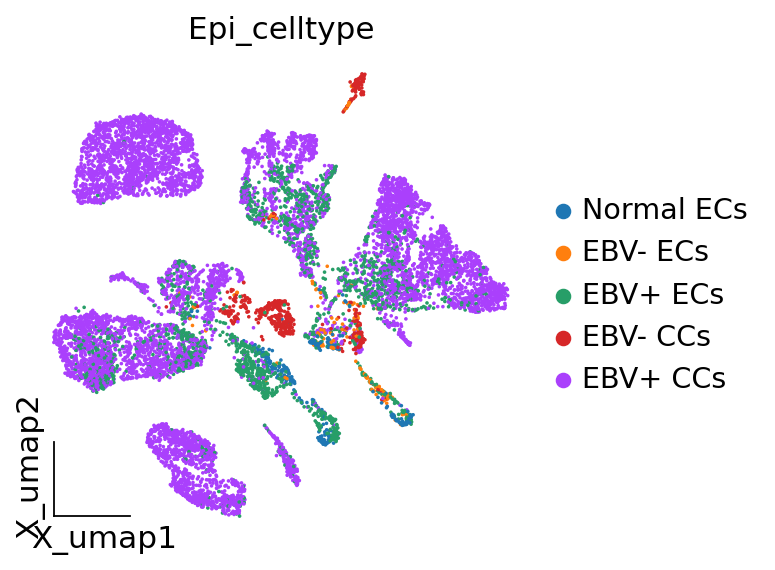

In [5]:
ov.utils.embedding(adata_epi,basis='X_umap',
                   color=['Epi_celltype'],
                   frameon='small',wspace=0.5)

## Generation of pseudo-bulk profiles

After the annotation of clusters into cell identities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterize them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results. 

The current best practice to correct for this is using a pseudo-bulk approach ([Squair J.W., et al 2021](https://doi.org/10.1038/s41467-021-25960-2)), which involves the following steps:

1. Subsetting the cell type(s) of interest to perform DEA.
2. Extracting their raw integer counts.
3. Summing their counts per gene into a single profile if they pass quality control.
4. Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).

We can pseudobulk using the function `decoupler.get_pseudobulk`. In this example, we are interested in summing the counts but other
modes are available, for more information check its argument `mode`.

We will store the raw counts in the `.layers` attribute so that we can use them
afterwards to generate pseudo-bulk profiles.

In [6]:
# Store raw counts in layers
adata_epi.X = adata_epi.X.toarray()
# adata_epi.X = np.round(adata_epi.X)
adata_epi.layers['counts'] = adata_epi.X

adata_epi.raw = adata_epi.copy() # This saves the raw count data in adata_epi.raw

# Normalize and log-transform
sc.pp.normalize_total(adata_epi, target_sum=1e4)
sc.pp.log1p(adata_epi)
adata_epi.layers['normalized'] = adata_epi.X

normalizing counts per cell
    finished (0:00:00)


In [7]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata=adata_epi,
    sample_col='orig.ident',
    groups_col='Epi_celltype',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)

It has generated a profile for each sample and cell type. We can plot their quality control metrics:

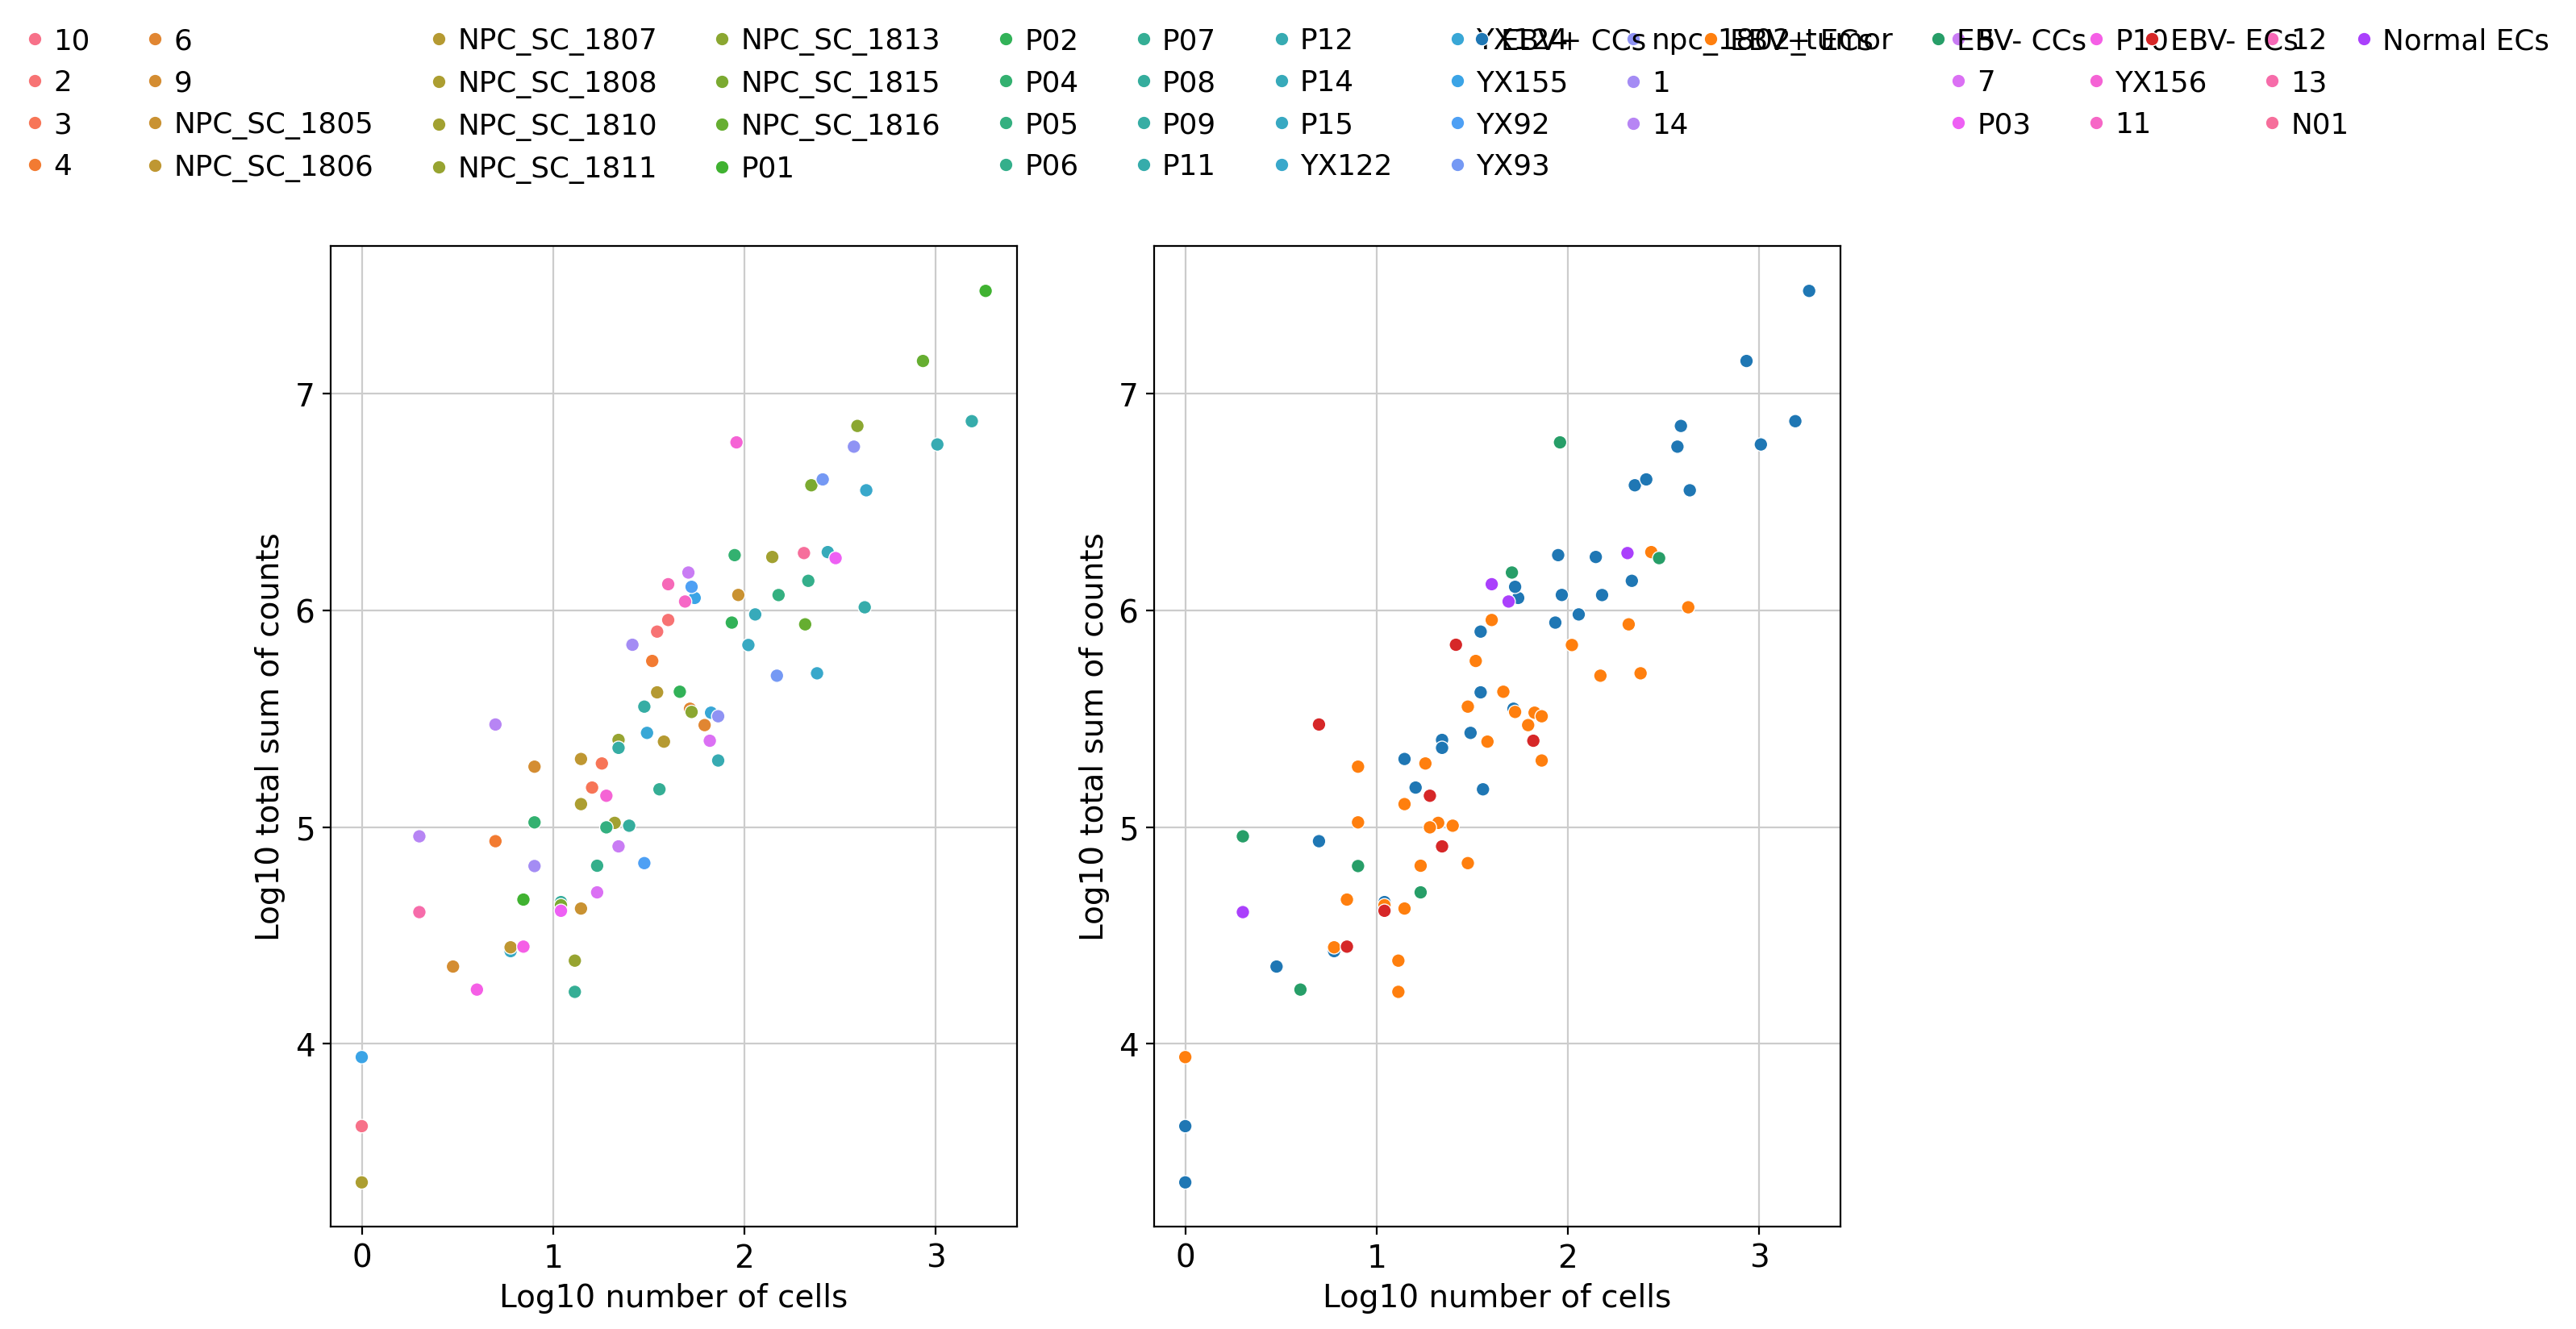

In [8]:
# Ensure that the plot_psbulk_samples function returns the figure object
fig = dc.plot_psbulk_samples(pdata, groupby=['orig.ident', 'Epi_celltype'], figsize=(12, 8), return_fig=True)

# After the plot is generated, access the axes and modify the legend
for ax in fig.axes:
    # Adjust the legend to be at the top and change the number of columns to 8
    ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.25), ncol=12, frameon=False, title=ax.get_title())

# Show the plot
plt.show()


There are two criteria to filter low quality samples: its number of cells (`psbulk_n_cells`), and its total sum of counts (`psbulk_counts`).
In these plots it can be seen that there are some samples of platelet cells that contain less than 10 cells, we might want to remove
them by using the arguments `min_cells` and `min_counts`. Note that these thresholds are arbitrary and will change depening on the
dataset, but a good rule of thumb is to have at least 10 cells with 1000 accumulated counts.

### Exploration of pseudobulk profiles
Now that we have generated the pseudobulk profiles for each patient and each cell type, let's explore the variability between them. For that, we will first do some simple preprocessing and then do a PCA

In [9]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


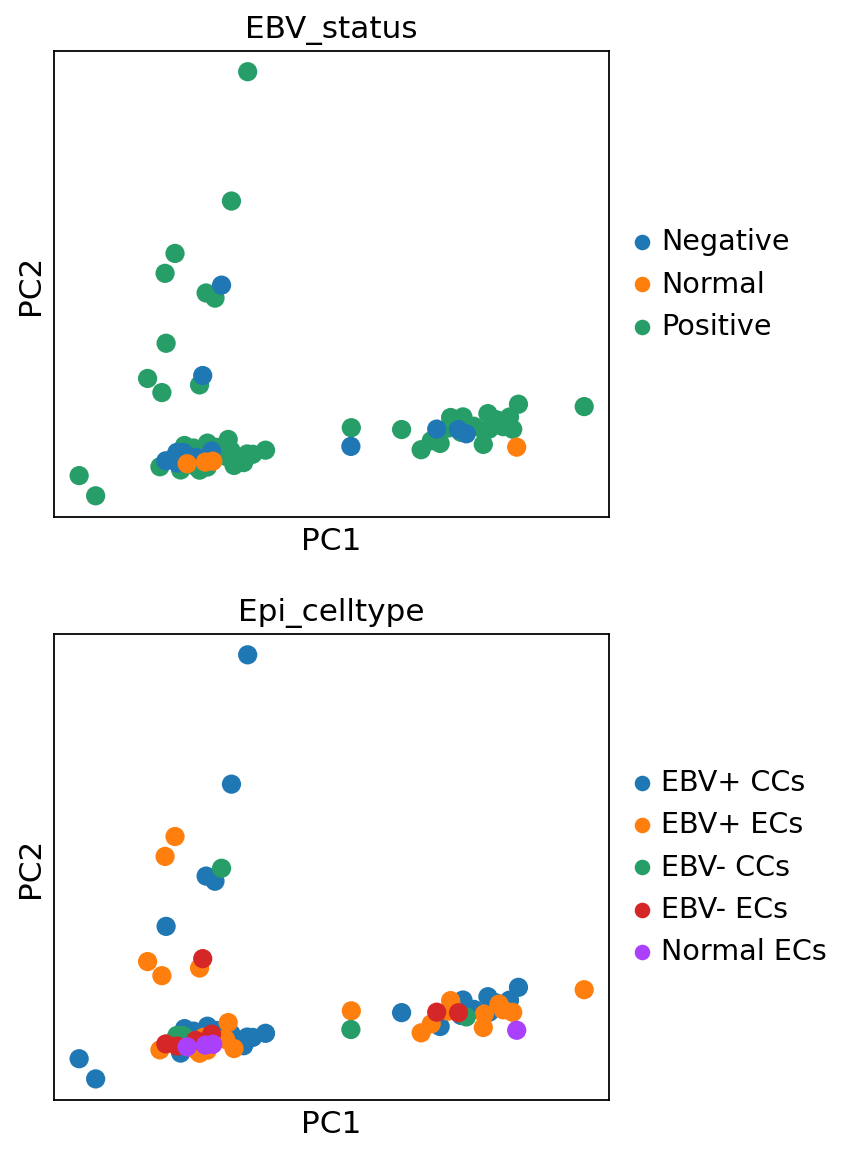

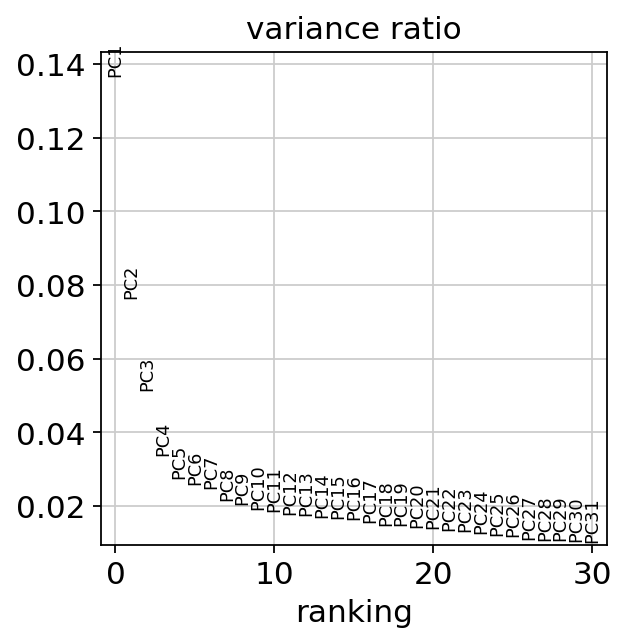

In [10]:
sc.pl.pca(pdata, color=['EBV_status', 'Epi_celltype'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

When looking at the PCA, it seems like the two first components explain most of the variance and they easily separate cell types from one another. In contrast, the principle components do not seem to be associated with disease status as such.

In order to have a better overview of the association of PCs with sample metadata, let's perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples

In [11]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['Sex', 'EBV_status', 'Epi_celltype', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

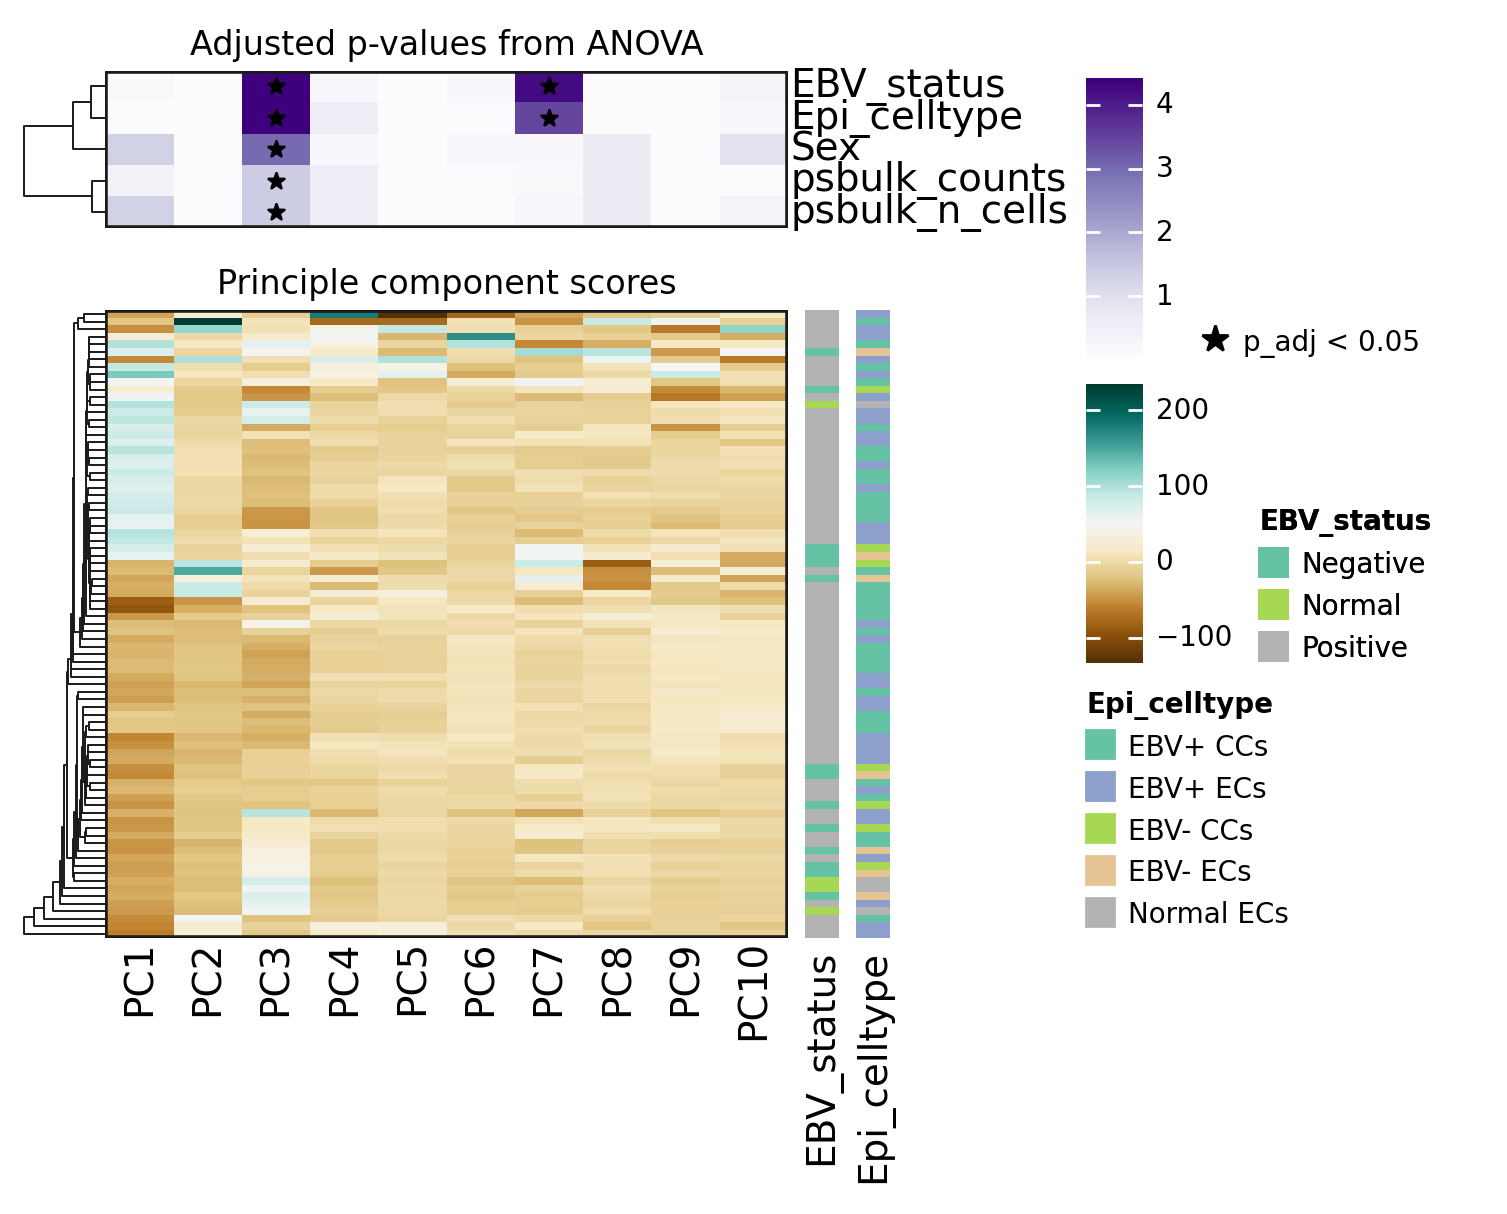

In [12]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['EBV_status', 'Epi_celltype'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

On the PCA plots above, T and B cells seemed not to be that well separated. However when looking at the hierarchical clustering in the heatmap, one can see that the inclusion of more PCs helps to distinguish them.

When looking at the p-values from the ANOVA models, it becomes clear that the top PCs, which explain most of the observed variability, are statistically associated with the `cell_type` category.

### Pseudo-bulk profile gene filtering
Additionally to filtering low quality samples, we can also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. Note that this step should be done at the cell type level, since each cell type may express different collection of genes.

For this vignette, we will explore the effects of COVID on T cells. Let's first select our samples of interest:

In [13]:
# Select cancer cell profiles
cancer = ((pdata.obs['Epi_celltype'].isin(['EBV- CCs', 'EBV+ CCs'])))

cancercells = pdata[cancer].copy()

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

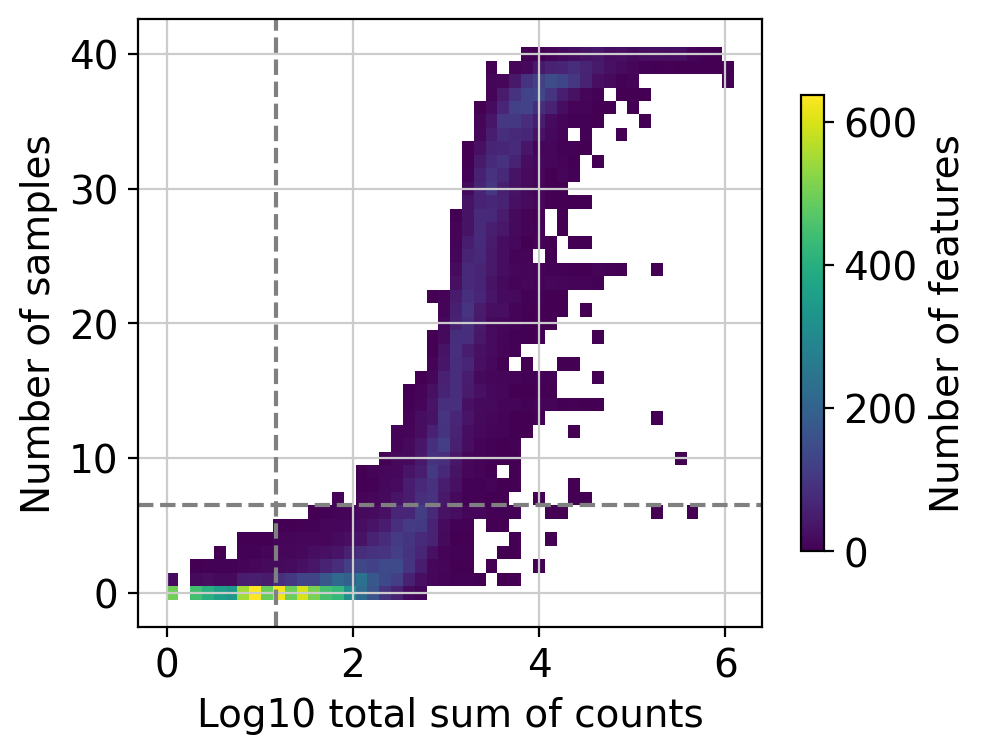

In [14]:
dc.plot_filter_by_expr(cancercells, group='Epi_celltype', min_count=10, min_total_count=15)

Here we can observe the frequency of genes with different total sum of counts and number of samples. The dashed lines indicate the current thresholds, meaning that only the genes in the upper-right corner are going to be kept. Filtering parameters is completely arbitrary, but a good rule of thumb is to identify bimodal distributions and split them modifying the available thresholds.
In this example, with the default values we would keep a good quantity of genes while filtering potential noisy genes.

<div class="alert alert-info">

**Note**
    
Changing the value of `min_count` will drastically change the distribution of "Number of samples", not change its threshold.
In case you want to lower or increase it, you need to play with the `group`, `large_n` and `min_prop` parameters. 


</div>

Once we are content with the threshold parameters, we can perform the actual filtering:

In [15]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(cancercells, group='Epi_celltype', min_count=10, min_total_count=15)

# Filter by these genes
cancercells = cancercells[:, genes].copy()
cancercells

AnnData object with n_obs × n_vars = 40 × 10952
    obs: 'orig.ident', 'Epi_celltype', 'Dataset', 'ID', 'EBV_status', 'Histology', 'Sex', 'Stage', 'Tissue', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'batch', '_scvi_batch', 'Cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'name', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'chromosome', 'start', 'end', 'gene_id', 'gene_name', 'mean', 'std'
    uns: 'log1p', 'pca', 'EBV_status_colors', 'Epi_celltype_colors', 'pca_anova'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

Another filtering strategy is to filter out genes that are not expressed in a percentage of cells and samples, as implemented
in `decoupler.filter_by_prop`.

### Contrast between conditions
Once we have generated robust pseudo-bulk profiles, we can compute DEA. For this example, we will perform a simple
experimental design where we compare the gene expression of cancer cells from EBV+ patients against EBV- patients. We will use the
python implementation of the framework DESeq2, but we could have used any other one (`limma` or `edgeR` for example).
For a better understanding how it works, check [DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that
more complex experimental designs can be used by adding more factors to the `design_factors` argument.

In [16]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [17]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=cancercells,
    design_factors='Epi_celltype',
    ref_level=['EBV+ CCs', 'EBV- CCs'],
    refit_cooks=True,
    inference=inference,
)

In [18]:
# Compute LFCs
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.92 seconds.

Fitting dispersion trend curve...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 1.94 seconds.

Fitting LFCs...
... done in 1.64 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 171 outlier genes.

Fitting dispersions...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.16 seconds.



In [19]:
# Extract contrast between EBV+ CCs vs EBV- CCs
stat_res = DeseqStats(
    dds,
    contrast=["Epi_celltype", 'EBV+ CCs', 'EBV- CCs'],
    inference=inference,
)

In [20]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Epi_celltype EBV+ CCs vs EBV- CCs
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2ML1    3.069595        0.711968  0.978291  0.727767  0.466756       NaN
A4GALT  26.026868       -2.065419  0.793114 -2.604190  0.009209  0.266776
AAAS    12.159786        0.662945  0.436469  1.518882  0.128792  0.625368
AACS    14.322000        0.720943  0.555909  1.296872  0.194675  0.686906
AAED1    5.232411        0.561996  0.995884  0.564319  0.572537       NaN
...           ...             ...       ...       ...       ...       ...
ZXDC     7.124450       -0.495248  0.677189 -0.731329  0.464578  0.849078
ZYG11B   9.456173       -0.294764  0.620085 -0.475361  0.634530  0.915309
ZYX     26.009703       -0.736178  0.414079 -1.777867  0.075426  0.538005
ZZEF1    9.386556        0.181375  0.691408  0.262327  0.793070  0.960029
ZZZ3     8.137443        2.218442  1.200284  1.848265  0.064564  0.509480

[10952 rows x 6 columns]


... done in 1.49 seconds.



In [21]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2ML1,3.069595,0.711968,0.978291,0.727767,0.466756,NaN
A4GALT,26.026868,-2.065419,0.793114,-2.604190,0.009209,0.266776
AAAS,12.159786,0.662945,0.436469,1.518882,0.128792,0.625368
AACS,14.322000,0.720943,0.555909,1.296872,0.194675,0.686906
AAED1,5.232411,0.561996,0.995884,0.564319,0.572537,NaN
...,...,...,...,...,...,...
ZXDC,7.124450,-0.495248,0.677189,-0.731329,0.464578,0.849078
ZYG11B,9.456173,-0.294764,0.620085,-0.475361,0.634530,0.915309
ZYX,26.009703,-0.736178,0.414079,-1.777867,0.075426,0.538005
ZZEF1,9.386556,0.181375,0.691408,0.262327,0.793070,0.960029


In [22]:
results_df.to_excel('Results/06.Epithelial/DEG_results.xlsx', index=True)

We can plot the obtained results in a volcano plot:

In [23]:
# 删除索引为 'AC090498.1' 的行
# results_df = results_df.drop(index='AC090498.1')

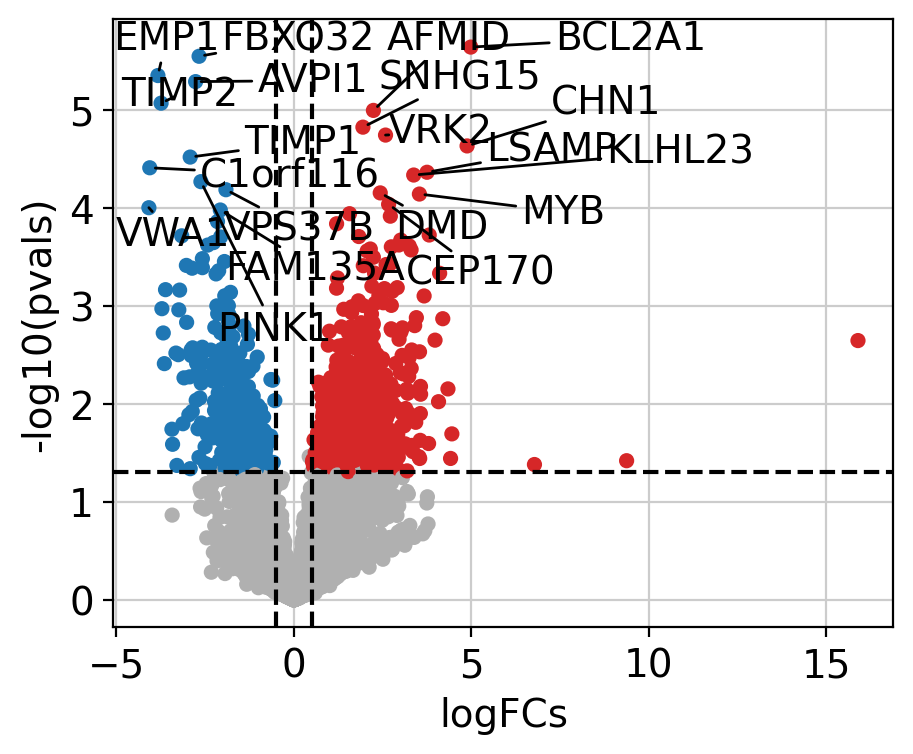

In [24]:
plt.rcParams['figure.figsize'] = [5,4]

dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='pvalue',
    color_pos='#D62728',  # JAMA风格的深红色
    color_neg='#1F77B4',  # JAMA风格的深蓝色
    color_null='#B0B0B0',  # 中性灰色
    top=20,
    figsize=(5, 4)
)

# 保存为 PDF
# plt.savefig('Results/06.Epithelial/06.Epithelial_DEG_VacanoPlot.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

##### Violinplot of selected stemnesee-related genes

In [25]:
# Select cancer cell profiles
cancer = ((adata_epi.obs['Epi_celltype'].isin(['EBV- CCs', 'EBV+ CCs'])))

adata_cancer = adata_epi[cancer].copy()
adata_cancer

AnnData object with n_obs × n_vars = 8691 × 24785
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'Dataset', 'ID', 'EBV_status', 'Histology', 'Age', 'Sex', 'Stage', 'Tissue', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'n_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'leiden_1_0', 'S_score', 'G2M_score', 'phase', 'gpt_celltype', 'batch', '_scvi_batch', '_scvi_labels', 'Cell_type', 'CellID', 'cnv_score', 'cnv_leiden', 'cnv_cluster', 'cnv_status', 'Epi_celltype', 'pt_via', 'CytoTRACE2_Score', 'CytoTRACE2_Potency', 'CytoTRACE2_Relative', 'preKNN_CytoTRACE2_Score', 'preKNN_CytoTRACE2_Potency'
    var: 'name', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'Cell_type_colors', 'CytoTRACE2_Potency_colors', 'Dataset_colors', 'EBV_status_colors', 'Epi_celltype_col

In [26]:
adata_cancer=ov.pp.preprocess(adata_cancer,mode='shiftlog|pearson',n_HVGs=2000)

Begin robust gene identification
After filtration, 24785/24785 genes are kept.     Among 24785 genes, 24785 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 9.51422905921936 seconds.
End of size normalization: shiftlog and HVGs selection pearson


In [27]:
ov.pp.scale(adata_cancer)

In [28]:
marker_genes = ["EPCAM", "SOX2", "MYC", "MYB", "SNHG15", "ALDH1A1", "SHMT2", "THY1", "CCND2", "MYB"]

In [29]:
jama_colors = ["#374E55FF","#DF8F44FF","#00A1D5FF","#B24745FF","#79AF97FF","#6A6599FF","#80796BFF"]

PyComplexHeatmap have been install version: 1.8.1
Dependency error: (pydeseq2 0.5.0 (/home/bio/miniforge3/envs/npc_env/lib/python3.10/site-packages), Requirement.parse('pydeseq2<=0.4.0,>=0.3'))
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 26.62764444444445 mm


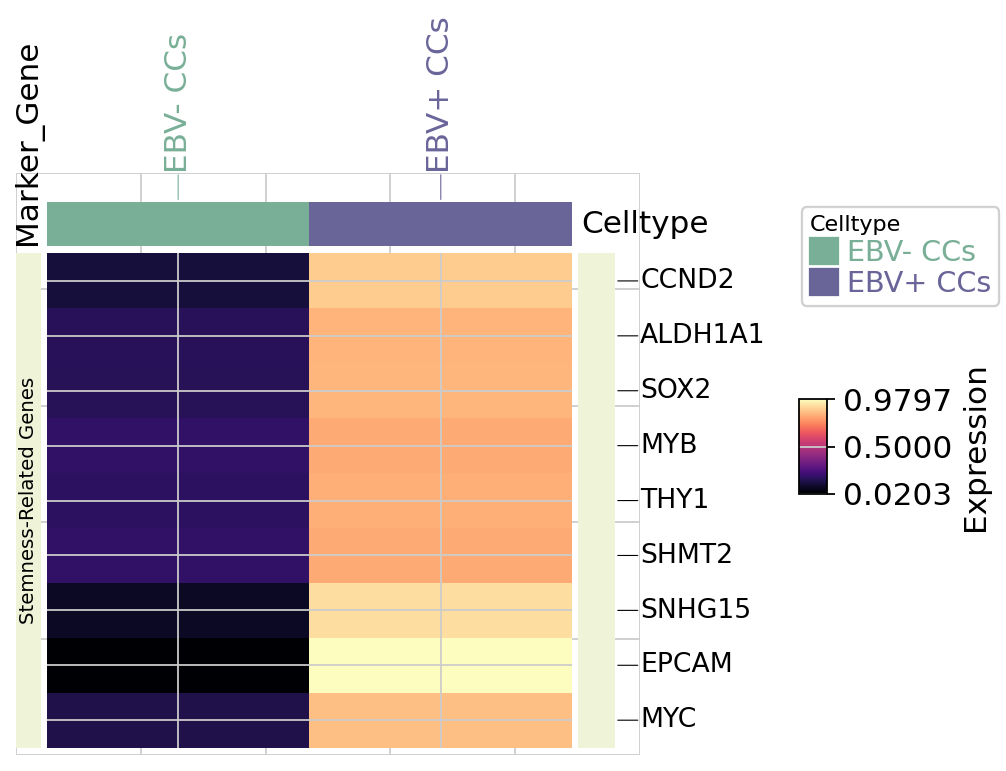

In [30]:
import pandas as pd
marker_genes_dict = {
    'Stemness-Related Genes': ["EPCAM", "SOX2", "MYC",  "MYB", "SNHG15", "ALDH1A1", "SHMT2", "THY1", "CCND2"],
}
# 构建颜色字典
cell_type_color = dict(zip(adata_cancer.obs['Epi_celltype'].cat.categories.tolist(), ["#79AF97FF","#6A6599FF"]))
color_dict = {'Stemness-Related Genes': '#EFF3D8'}

gene_color_dict = {}
gene_color_dict_black = {}
for cell_type, genes in marker_genes_dict.items():
    for gene in genes:
        gene_color_dict[gene] = cell_type_color
        gene_color_dict_black[gene] = '#000000'

cm = ov.pl.complexheatmap(adata_cancer,
                          groupby='Epi_celltype',
                          figsize=(5, 4),
                          layer='scaled',
                          use_raw=False,
                          standard_scale='obs',
                          col_color_bars=cell_type_color,
                          col_color_labels=cell_type_color,
                          left_color_bars=color_dict,
                          left_color_labels=None,
                          right_color_bars=color_dict,
                          right_color_labels=gene_color_dict_black,
                          marker_genes_dict=marker_genes_dict,
                          cmap='magma',  # RdBu_r parula, jet, coolwarm viridis
                          legend_gap=15,
                          legend_hpad=0,
                          left_add_text=True,
                          col_split_gap=2,  # 这里可以调整列之间的间隔
                          row_split_gap=5,  # 增加行之间的间隔
                          col_height=6,
                          left_height=4,
                          right_height=6,
                          col_split=None,
                          row_cluster=True,
                          col_cluster=False,
                          value_name='Gene',
                          xlabel="",
                          label='Expression',
                          save=True,
                          show=False,
                          legend=True,
                          plot_legend=True,
                          right_fontsize=12,
                          save_pathway = "Results/06.Epithelial/06.Epithelial_Stemness_Genes_Complexheatmap.pdf",
                         )


After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [31]:
mat = results_df[['stat']].T.rename(index={'stat': 'Cancer cell'})
mat

,A2ML1,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUFSP,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Cancer cell,0.727767,-2.60419,1.518882,1.296872,0.564319,0.941073,0.146276,0.55891,0.853063,0.416266,...,1.25245,-0.29767,0.662828,2.278391,0.640909,-0.731329,-0.475361,-1.777867,0.262327,1.848265


## Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

</div> 

In [32]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


### Activity inference with Univariate Linear Model (ULM)

To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

We can run `ulm` with a one-liner:

In [33]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
Cancer cell,-0.764177,1.499134,-0.817179,-1.212233,-0.658732,-1.006246,0.140617,1.299834,-0.494186,-1.7221,...,-1.548019,-0.366726,-0.097567,1.386101,0.246058,-0.694412,-1.067794,0.077376,-2.396847,-0.202267


Let us plot the obtained scores for the top active/inactive transcription factors:

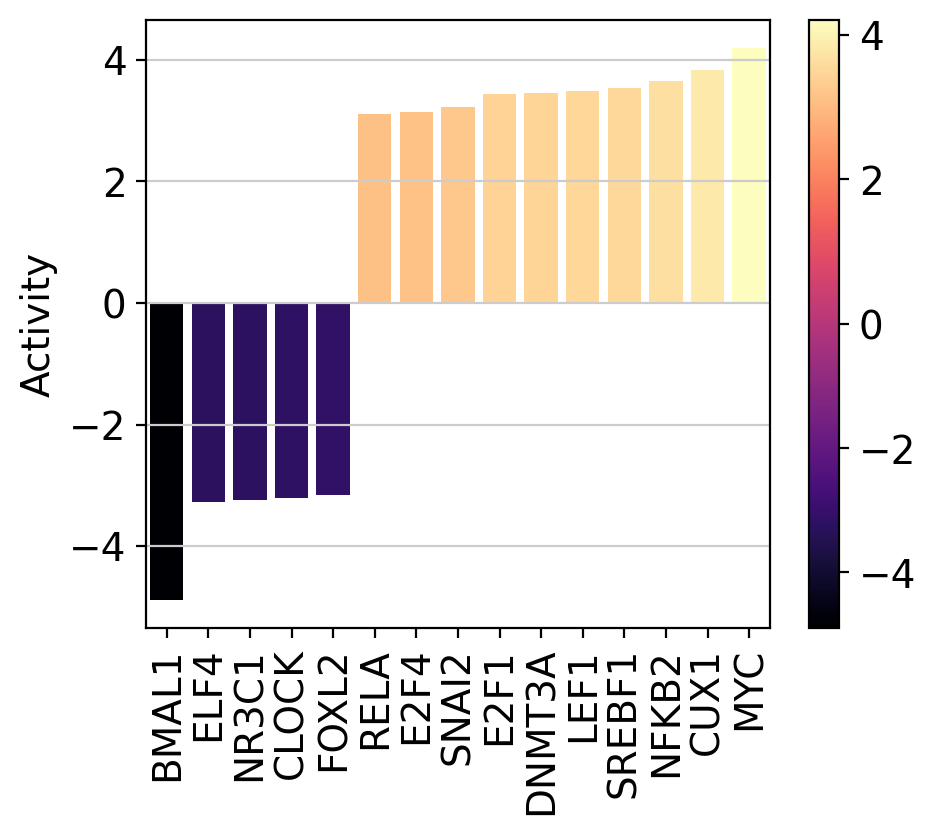

In [34]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='Cancer cell',
    top=15,
    vertical=False,
    cmap='magma', # RdBu_r parula, jet, coolwarm twilight twilight_shifted summer viridis
    figsize=(5, 4)
)

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.Epithelial_active_TFs.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

In accordance to the previous pathway results, T cells seem to activate for TFs responsible for cell growth (E2F4, TFDP1, E2F1).

Like with pathways, we can explore how the target genes look like:

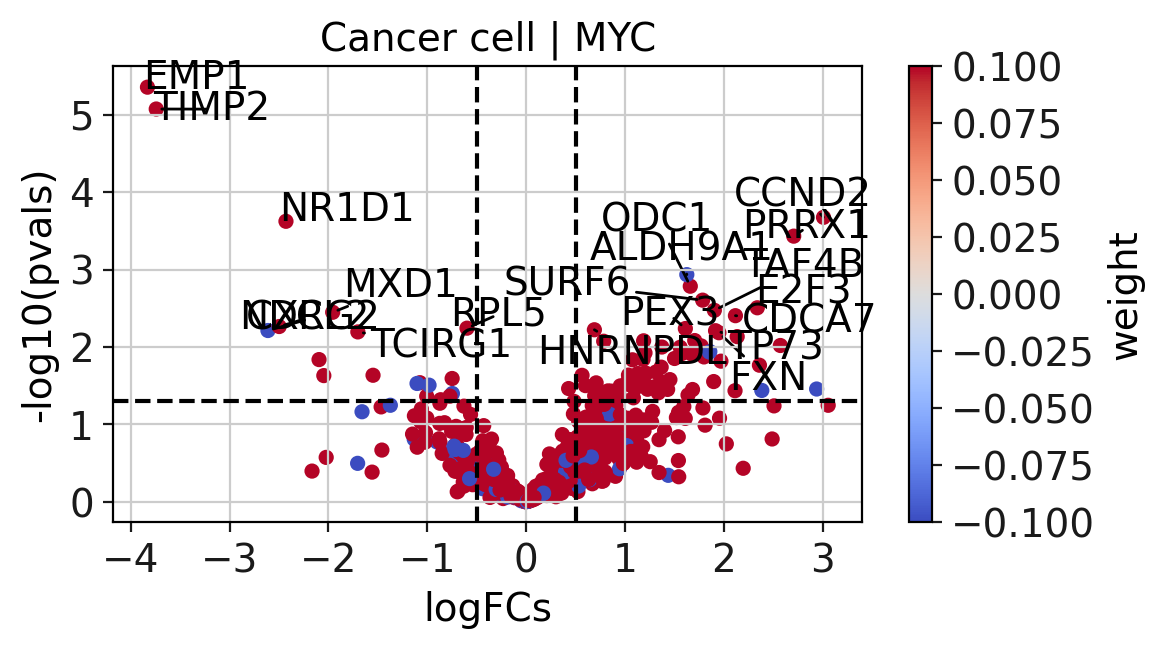

In [35]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'Cancer cell'})
pvals = results_df[['pvalue']].T.rename(index={'pvalue': 'Cancer cell'})

# Plot
dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='Cancer cell',
    name='MYC',
    net=collectri,
    top=20,
    sign_thr=0.05,
    lFCs_thr=0.5
)

# 保存为 PDF
# 设置整体风格和字体
plt.gcf().set_size_inches(6, 3)
sns.set(style='ticks')  # 你也可以改成 'whitegrid', 'white'
plt.rcParams.update({
    'font.size': 9,            # 全局字体大小
    'axes.labelsize': 10,       # 坐标轴标签字体
    'xtick.labelsize': 9,       # x轴刻度
    'ytick.labelsize': 9,       # y轴刻度
    'legend.fontsize': 9,
    'figure.titlesize': 11,
    'pdf.fonttype': 42,         # 确保 PDF 矢量输出兼容性
    'ps.fonttype': 42
})

plt.savefig('Results/06.Epithelial/06.Epithelial_MYC_VacanoPlot.pdf', format='pdf', bbox_inches='tight')

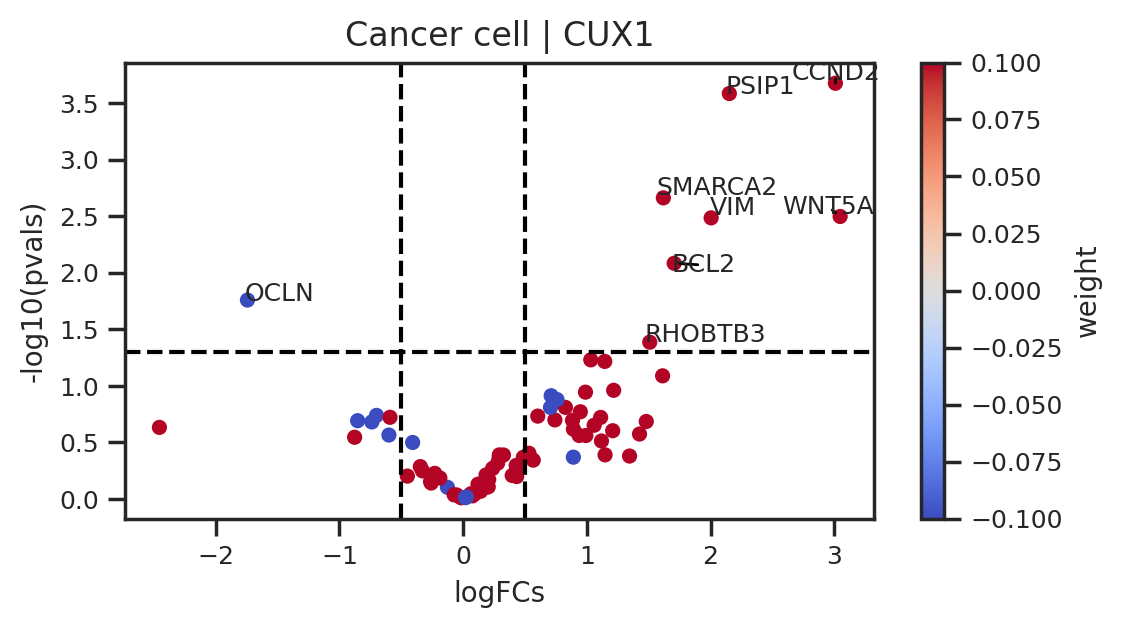

In [36]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'Cancer cell'})
pvals = results_df[['pvalue']].T.rename(index={'pvalue': 'Cancer cell'})

# Plot
dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='Cancer cell',
    name='CUX1',
    net=collectri,
    top=20,
    sign_thr=0.05,
    lFCs_thr=0.5
)

# 保存为 PDF
# 设置整体风格和字体
plt.gcf().set_size_inches(6, 3)
sns.set(style='ticks')  # 你也可以改成 'whitegrid', 'white'
plt.rcParams.update({
    'font.size': 9,            # 全局字体大小
    'axes.labelsize': 10,       # 坐标轴标签字体
    'xtick.labelsize': 9,       # x轴刻度
    'ytick.labelsize': 9,       # y轴刻度
    'legend.fontsize': 9,
    'figure.titlesize': 11,
    'pdf.fonttype': 42,         # 确保 PDF 矢量输出兼容性
    'ps.fonttype': 42
})

plt.savefig('Results/06.Epithelial/06.Epithelial_CUX1_VacanoPlot.pdf', format='pdf', bbox_inches='tight')

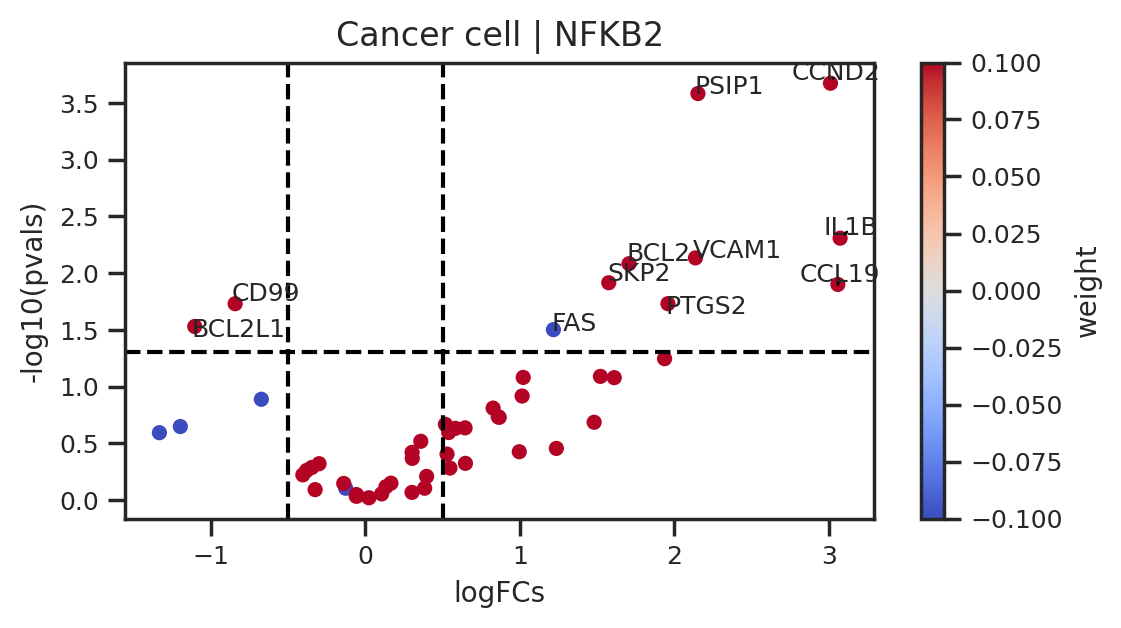

In [37]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'Cancer cell'})
pvals = results_df[['pvalue']].T.rename(index={'pvalue': 'Cancer cell'})

# Plot
dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='Cancer cell',
    name='NFKB2',
    net=collectri,
    top=20,
    sign_thr=0.05,
    lFCs_thr=0.5
)

# 保存为 PDF
# 设置整体风格和字体
plt.gcf().set_size_inches(6, 3)
sns.set(style='ticks')  # 你也可以改成 'whitegrid', 'white'
plt.rcParams.update({
    'font.size': 9,            # 全局字体大小
    'axes.labelsize': 10,       # 坐标轴标签字体
    'xtick.labelsize': 9,       # x轴刻度
    'ytick.labelsize': 9,       # y轴刻度
    'legend.fontsize': 9,
    'figure.titlesize': 11,
    'pdf.fonttype': 42,         # 确保 PDF 矢量输出兼容性
    'ps.fonttype': 42
})
plt.savefig('Results/06.Epithelial/06.Epithelial_NFKB2_VacanoPlot.pdf', format='pdf', bbox_inches='tight')

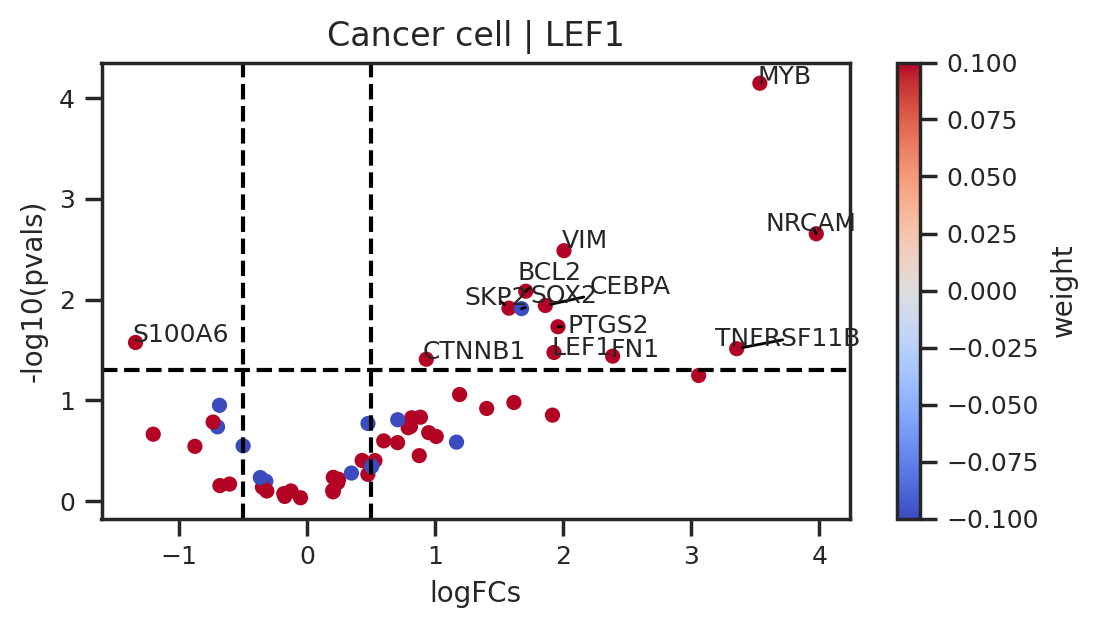

In [38]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'Cancer cell'})
pvals = results_df[['pvalue']].T.rename(index={'pvalue': 'Cancer cell'})

# Plot
dc.plot_volcano(
    logFCs=logFCs,
    pvals=pvals,
    contrast='Cancer cell',
    name='LEF1',
    net=collectri,
    top=20,
    sign_thr=0.05,
    lFCs_thr=0.5
)

# 保存为 PDF
# 设置整体风格和字体
plt.gcf().set_size_inches(6, 3)
sns.set(style='ticks')  # 你也可以改成 'whitegrid', 'white'
plt.rcParams.update({
    'font.size': 9,            # 全局字体大小
    'axes.labelsize': 10,       # 坐标轴标签字体
    'xtick.labelsize': 9,       # x轴刻度
    'ytick.labelsize': 9,       # y轴刻度
    'legend.fontsize': 9,
    'figure.titlesize': 11,
    'pdf.fonttype': 42,         # 确保 PDF 矢量输出兼容性
    'ps.fonttype': 42
})
plt.savefig('Results/06.Epithelial/06.Epithelial_LEF1_VacanoPlot.pdf', format='pdf', bbox_inches='tight')

We can also plot the network of interesting TFs (top and bottom by activity) and color the nodes by activity and target gene expression:

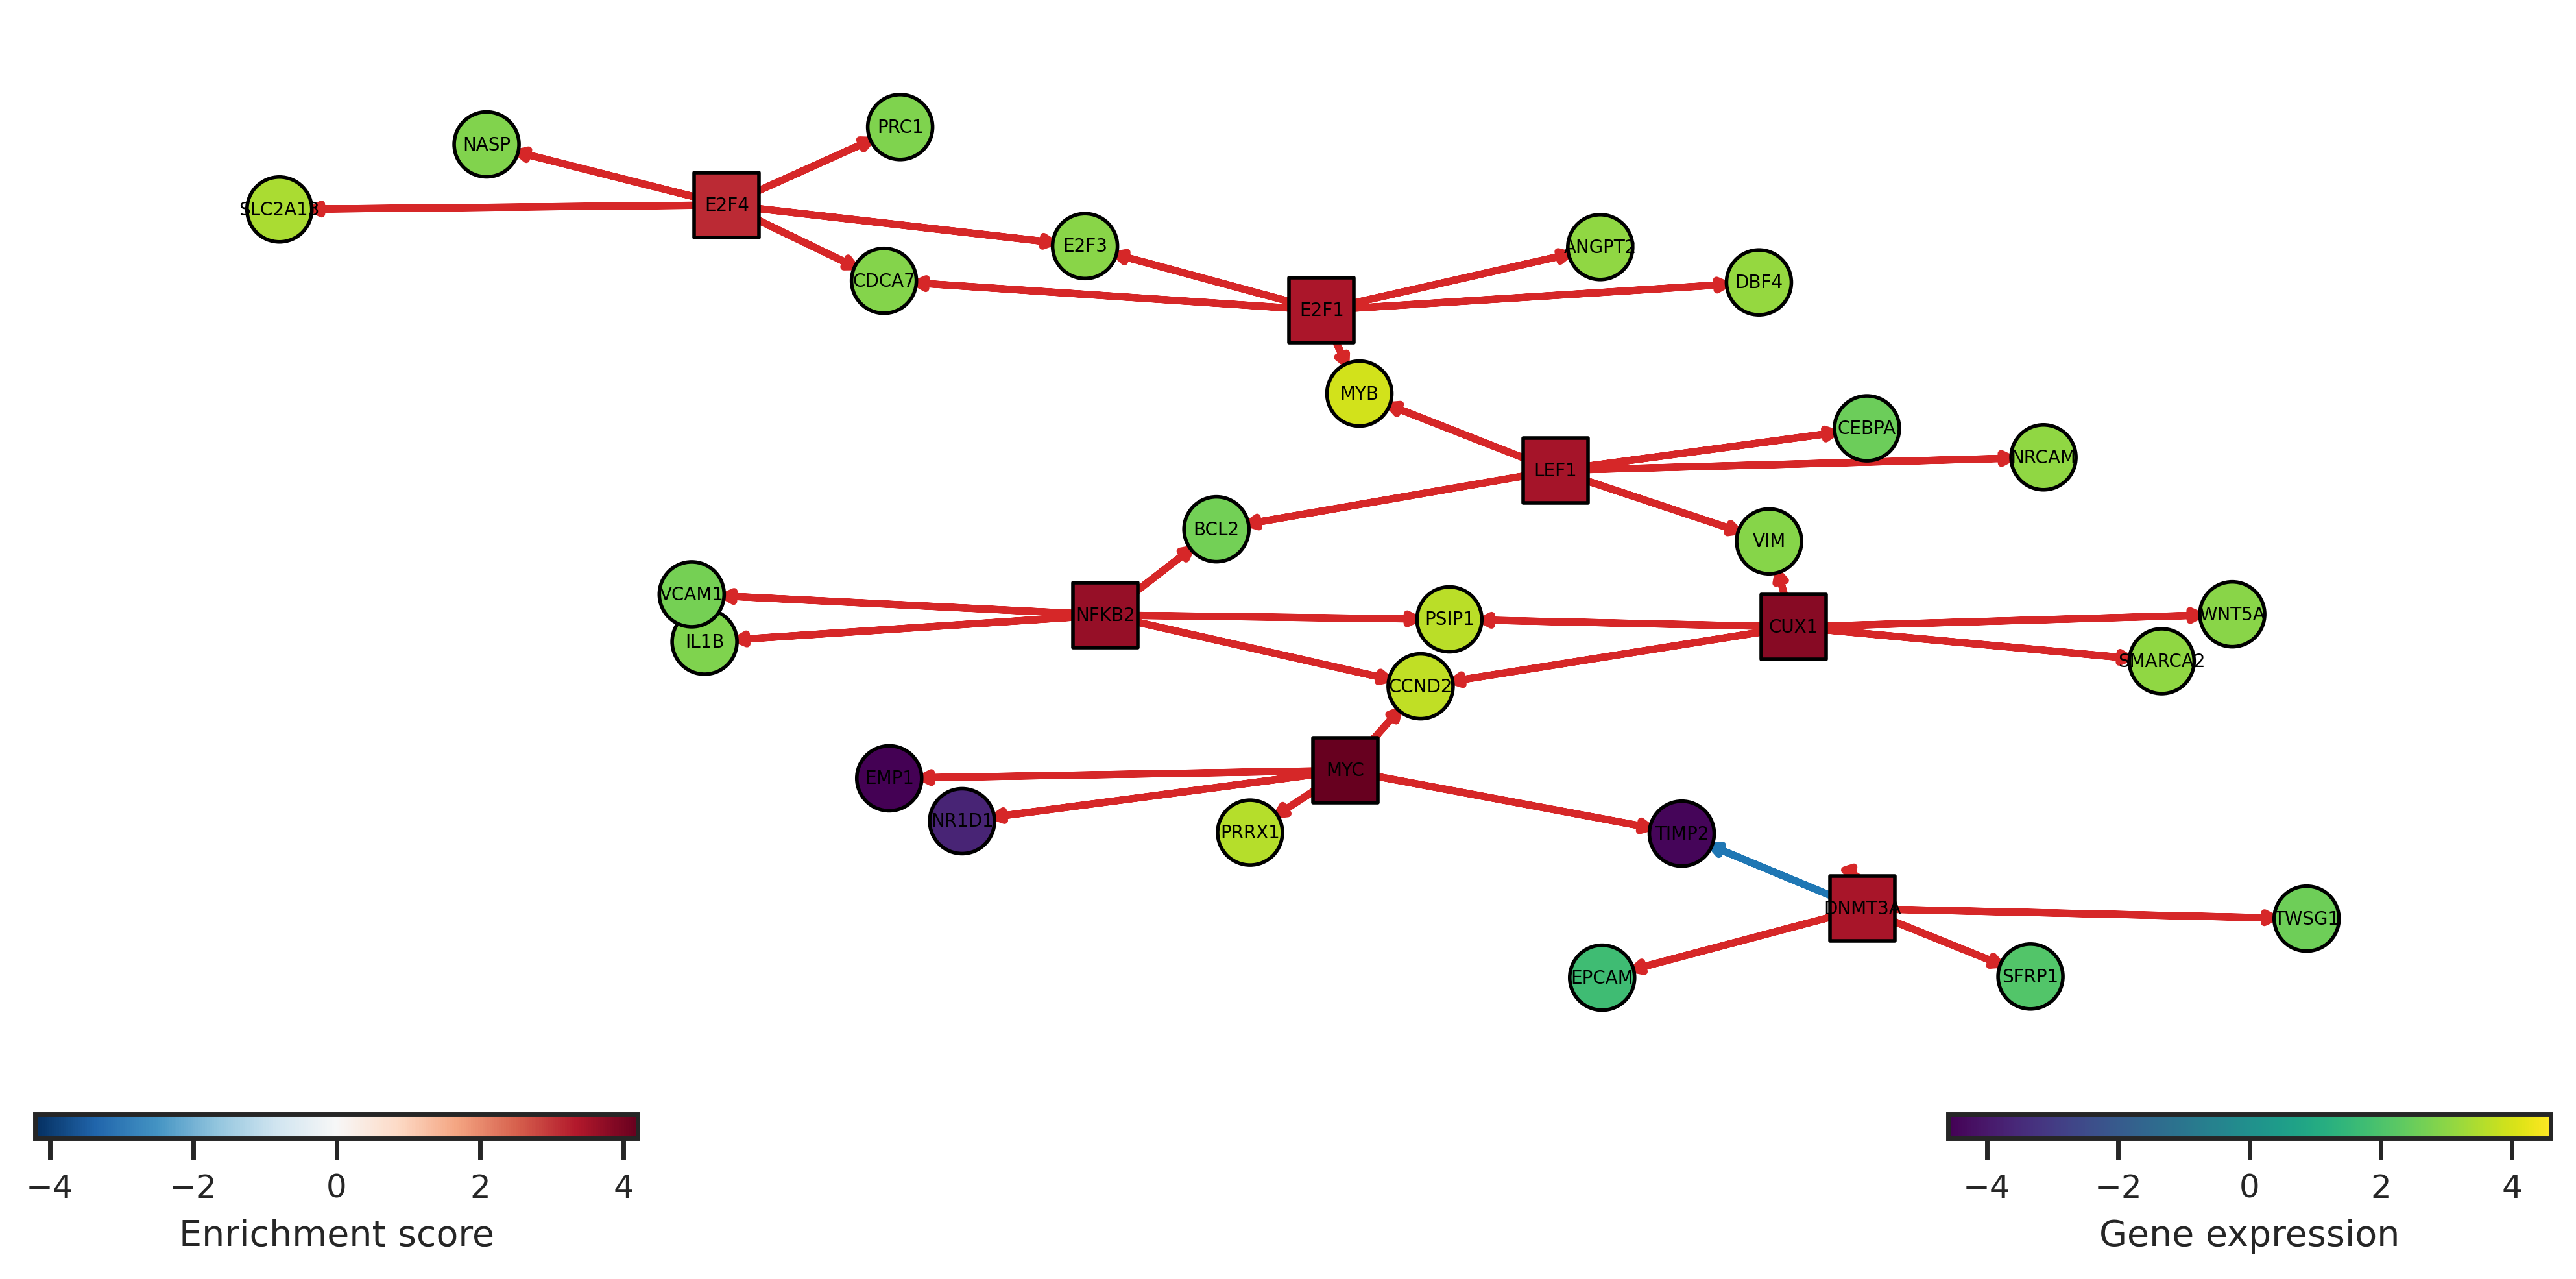

In [39]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['MYC','CUX1','NFKB2', 'LEF1','DNMT3A','E2F1','SNAIL','E2F4'],
    n_targets=5,
    node_size=100,
    label_size=5,
    figsize=(10, 5),
    dpi=200,
    c_pos_w='#D62728',  # JAMA风格的深红色
    c_neg_w='#1F77B4',  # JAMA风格的深蓝色
    vcenter=True,
)

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.Epithelial_TF_regulation_network.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


Green edges are positive regulation (activation), red edges are negative regulation (inactivation):

## Pathway activity inference

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [40]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


### Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

We can run `mlm` with a one-liner:

In [41]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
Cancer cell,-1.359004,-3.630913,2.578025,-2.397684,2.581539,5.78959,1.507879,3.557435,-1.095917,-0.556264,-3.94681,-2.499641,0.695674,-2.188906


Let us plot the obtained scores:

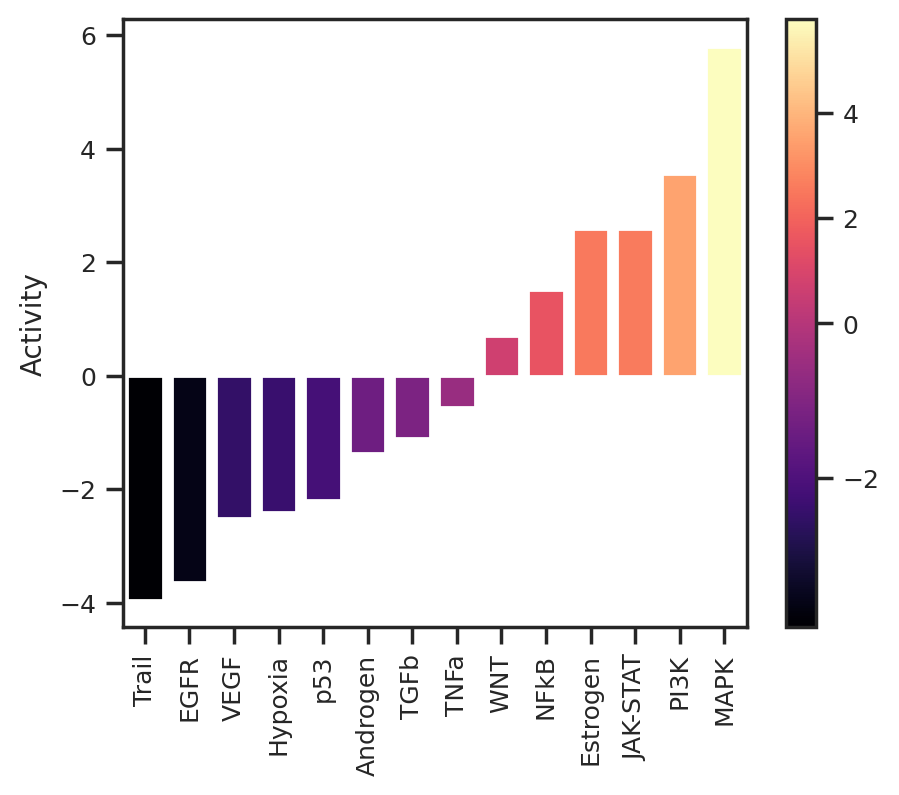

In [42]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='Cancer cell',
    top=15,
    vertical=False,
    cmap='magma', # RdBu_r parula, jet, coolwarm twilight twilight_shifted summer viridis
    figsize=(5, 4)
)

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.Epithelial_pathway_activities.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

It looks like JAK-STAT, a known immunity pathway is more active in T cells from COVID-19 patients than in controls. To further explore how the target genes of a pathway of interest behave, we can plot them in scatter plot:

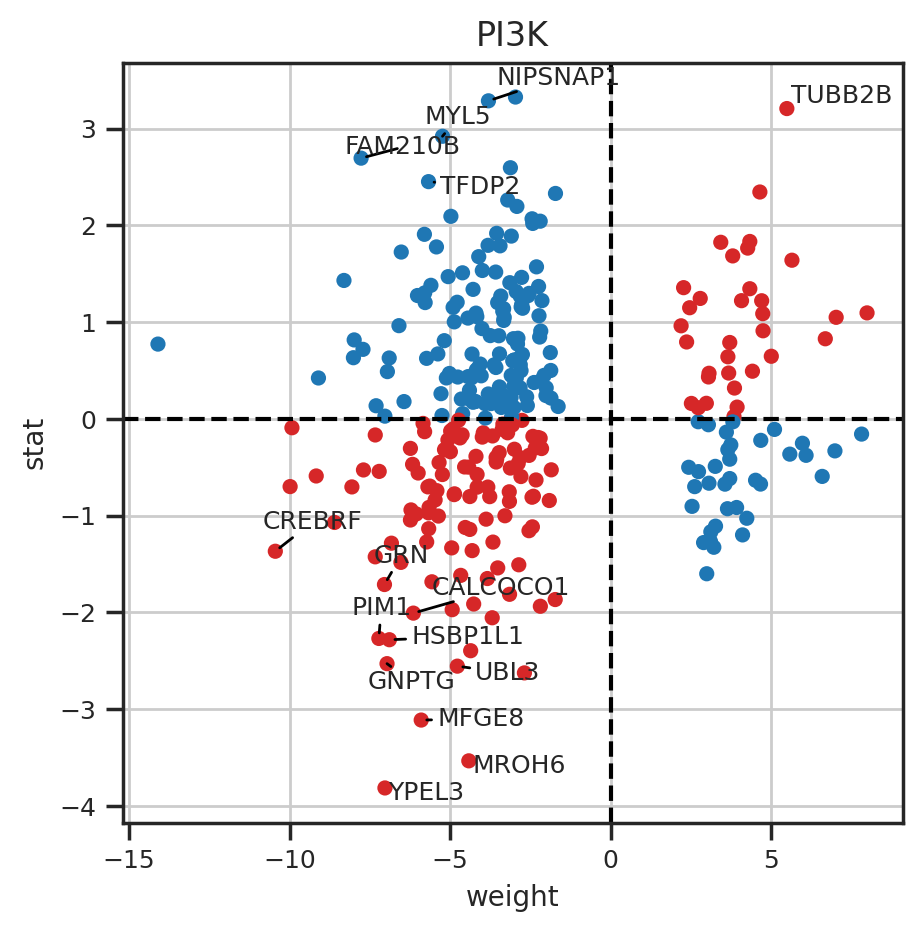

In [43]:
dc.plot_targets(
    data=results_df,
    stat='stat',
    source_name='PI3K',
    net=progeny,
    top=15
)

The observed activation of JAK-STAT is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

## Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [44]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


As an example, we will use the hallmark and stemness gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [45]:
# Filter by hallmark and stemness
# msigdb = msigdb[(msigdb['collection'] == 'hallmark') | (msigdb['geneset'] == 'MALTA_CURATED_STEMNESS_MARKERS')]
msigdb = msigdb[(msigdb['collection'] == 'hallmark')]

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
# Ensure that 'geneset' contains 'HALLMARK_' before splitting
def safe_split(name):
    if 'HALLMARK_' in name:
        return name.split('HALLMARK_')[1]
    else:
        return 'CURATED_STEMNESS'  # Or return a default value like 'Unknown' if you prefer

# Apply the safe_split function to the 'geneset' column
msigdb.loc[:, 'geneset'] = msigdb['geneset'].apply(safe_split)

# Check the result
msigdb

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


In [46]:
# Read gmt file with NA filtering
def read_gmt(gmt_file):
    with open(gmt_file, 'r') as f:
        gene_sets = {}
        for line in f:
            parts = line.strip().split('\t')  # 按制表符分隔
            gene_name = parts[0]  # 基因集名称
            genes = [gene for gene in parts[2:] if gene and gene != "NA"]  # 过滤掉空值和 "NA"
            gene_sets[gene_name] = genes
    return gene_sets


In [47]:
# 示例用法
gmt_file = 'Dataset/CURATED_STEMNESS_GENESET_PNAS_2019.gmt'
gene_sets = read_gmt(gmt_file)

gene_sets

{'MALTA_CURATED_STEMNESS_MARKERS': ['DNMT3B',
  'PFAS',
  'XRCC5',
  'HAUS6',
  'TET1',
  'IGF2BP1',
  'PLAA',
  'TEX10',
  'MSH6',
  'DLGAP5',
  'SKIV2L2',
  'SOHLH2',
  'RRAS2',
  'PAICS',
  'CPSF3',
  'LIN28B',
  'IPO5',
  'BMPR1A',
  'ZNF788',
  'ASCC3',
  'FANCB',
  'HMGA2',
  'TRIM24',
  'ORC1',
  'HDAC2',
  'HESX1',
  'INHBE',
  'MIS18A',
  'DCUN1D5',
  'MRPL3',
  'CENPH',
  'MYCN',
  'HAUS1',
  'GDF3',
  'TBCE',
  'RIOK2',
  'BCKDHB',
  'RAD1',
  'NREP',
  'ADH5',
  'PLRG1',
  'ROR1',
  'RAB3B',
  'DIAPH3',
  'GNL2',
  'FGF2',
  'NMNAT2',
  'KIF20A',
  'CENPI',
  'DDX1',
  'XXYLT1',
  'GPR176',
  'BBS9',
  'C14orf166',
  'BOD1',
  'CDC123',
  'SNRPD3',
  'FAM118B',
  'DPH3',
  'EIF2B3',
  'RPF2',
  'APLP1',
  'DACT1',
  'PDHB',
  'C14orf119',
  'DTD1',
  'SAMM50',
  'CCL26',
  'MED20',
  'UTP6',
  'RARS2',
  'ARMCX2',
  'RARS',
  'MTHFD2',
  'DHX15',
  'HTR7',
  'MTHFD1L',
  'ARMC9',
  'XPOT',
  'IARS',
  'HDX',
  'ACTRT3',
  'ERCC2',
  'TBC1D16',
  'GARS',
  'KIF7',
  'UBE2K',

In [48]:
# 创建新的 DataFrame
new_data = pd.DataFrame({
    'genesymbol': [gene for gene in gene_sets['MALTA_CURATED_STEMNESS_MARKERS']],
    'collection': ['hallmark'] * len(gene_sets['MALTA_CURATED_STEMNESS_MARKERS']),
    'geneset': ['STEMNESS'] * len(gene_sets['MALTA_CURATED_STEMNESS_MARKERS'])
})
new_data

,genesymbol,collection,geneset
0,DNMT3B,hallmark,STEMNESS
1,PFAS,hallmark,STEMNESS
2,XRCC5,hallmark,STEMNESS
3,HAUS6,hallmark,STEMNESS
4,TET1,hallmark,STEMNESS
...,...,...,...
104,SEC11A,hallmark,STEMNESS
105,DIMT1,hallmark,STEMNESS
106,TM2D2,hallmark,STEMNESS
107,FST,hallmark,STEMNESS


In [49]:
# 将新的数据合并到现有的 msigdb 数据集中
msigdb = pd.concat([msigdb, new_data], ignore_index=True)

# 显示合并后的 DataFrame
print(msigdb)

     genesymbol collection                  geneset
0          MAFF   hallmark      IL2_STAT5_SIGNALING
1          MAFF   hallmark              COAGULATION
2          MAFF   hallmark                  HYPOXIA
3          MAFF   hallmark  TNFA_SIGNALING_VIA_NFKB
4          MAFF   hallmark               COMPLEMENT
...         ...        ...                      ...
7422     SEC11A   hallmark                 STEMNESS
7423      DIMT1   hallmark                 STEMNESS
7424      TM2D2   hallmark                 STEMNESS
7425        FST   hallmark                 STEMNESS
7426       GBE1   hallmark                 STEMNESS

[7427 rows x 3 columns]


### Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
     
We can run `ora` with a simple one-liner:

In [50]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['pvalue'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head(100)

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.080000,6.337069e-02,9.505604e-02,1.570571,4.332819,ADIPOR2;APOE;ARL4A;DLD;FAH;GBE1;HADH;HIBCH;HSP...
1,ALLOGRAFT_REJECTION,200,0.080000,6.337069e-02,9.505604e-02,1.570571,4.332819,ABCE1;CCL19;CCND2;DEGS1;FAS;ICOSLG;IFNAR2;IL15...
2,ANDROGEN_RESPONSE,100,0.140000,7.407175e-04,2.698328e-03,2.762113,19.909010,ACTN1;B4GALT1;DBI;ELOVL5;FADS1;IQGAP2;LIFR;MAP...
3,ANGIOGENESIS,36,0.055556,5.720637e-01,6.078177e-01,1.300458,0.726312,CCND2;TIMP1
4,APICAL_JUNCTION,200,0.100000,4.513908e-03,1.151047e-02,1.958868,10.579046,ACTN1;ADAM15;ADAM23;ADAM9;AKT3;B4GALT1;CD274;C...
5,APICAL_SURFACE,44,0.136364,2.681626e-02,5.065294e-02,2.782811,10.070288,ADAM10;ADIPOR2;B4GALT1;DCBLD2;FLOT2;LYPD3
6,APOPTOSIS,161,0.111801,2.087383e-03,5.914252e-03,2.194724,13.545492,BCL2L1;BID;CCND2;CLU;CTNNB1;DAP3;EMP1;ERBB3;FA...
7,BILE_ACID_METABOLISM,112,0.107143,1.486665e-02,3.296517e-02,2.121779,8.929796,ABCA3;ALDH9A1;ATXN1;BCAR3;CROT;FADS1;FADS2;FDX...
8,CHOLESTEROL_HOMEOSTASIS,74,0.162162,4.549078e-04,1.784638e-03,3.210151,24.703448,ATF5;CD9;CLU;CPEB2;CTNNB1;CXCL16;ETHE1;FADS2;F...
9,COAGULATION,138,0.065217,3.030273e-01,3.769364e-01,1.304365,1.557324,ADAM9;CD9;CLU;CTSB;FN1;MAFF;MMP11;SERPINB2;TIMP1


Then we can visualize the most enriched terms:

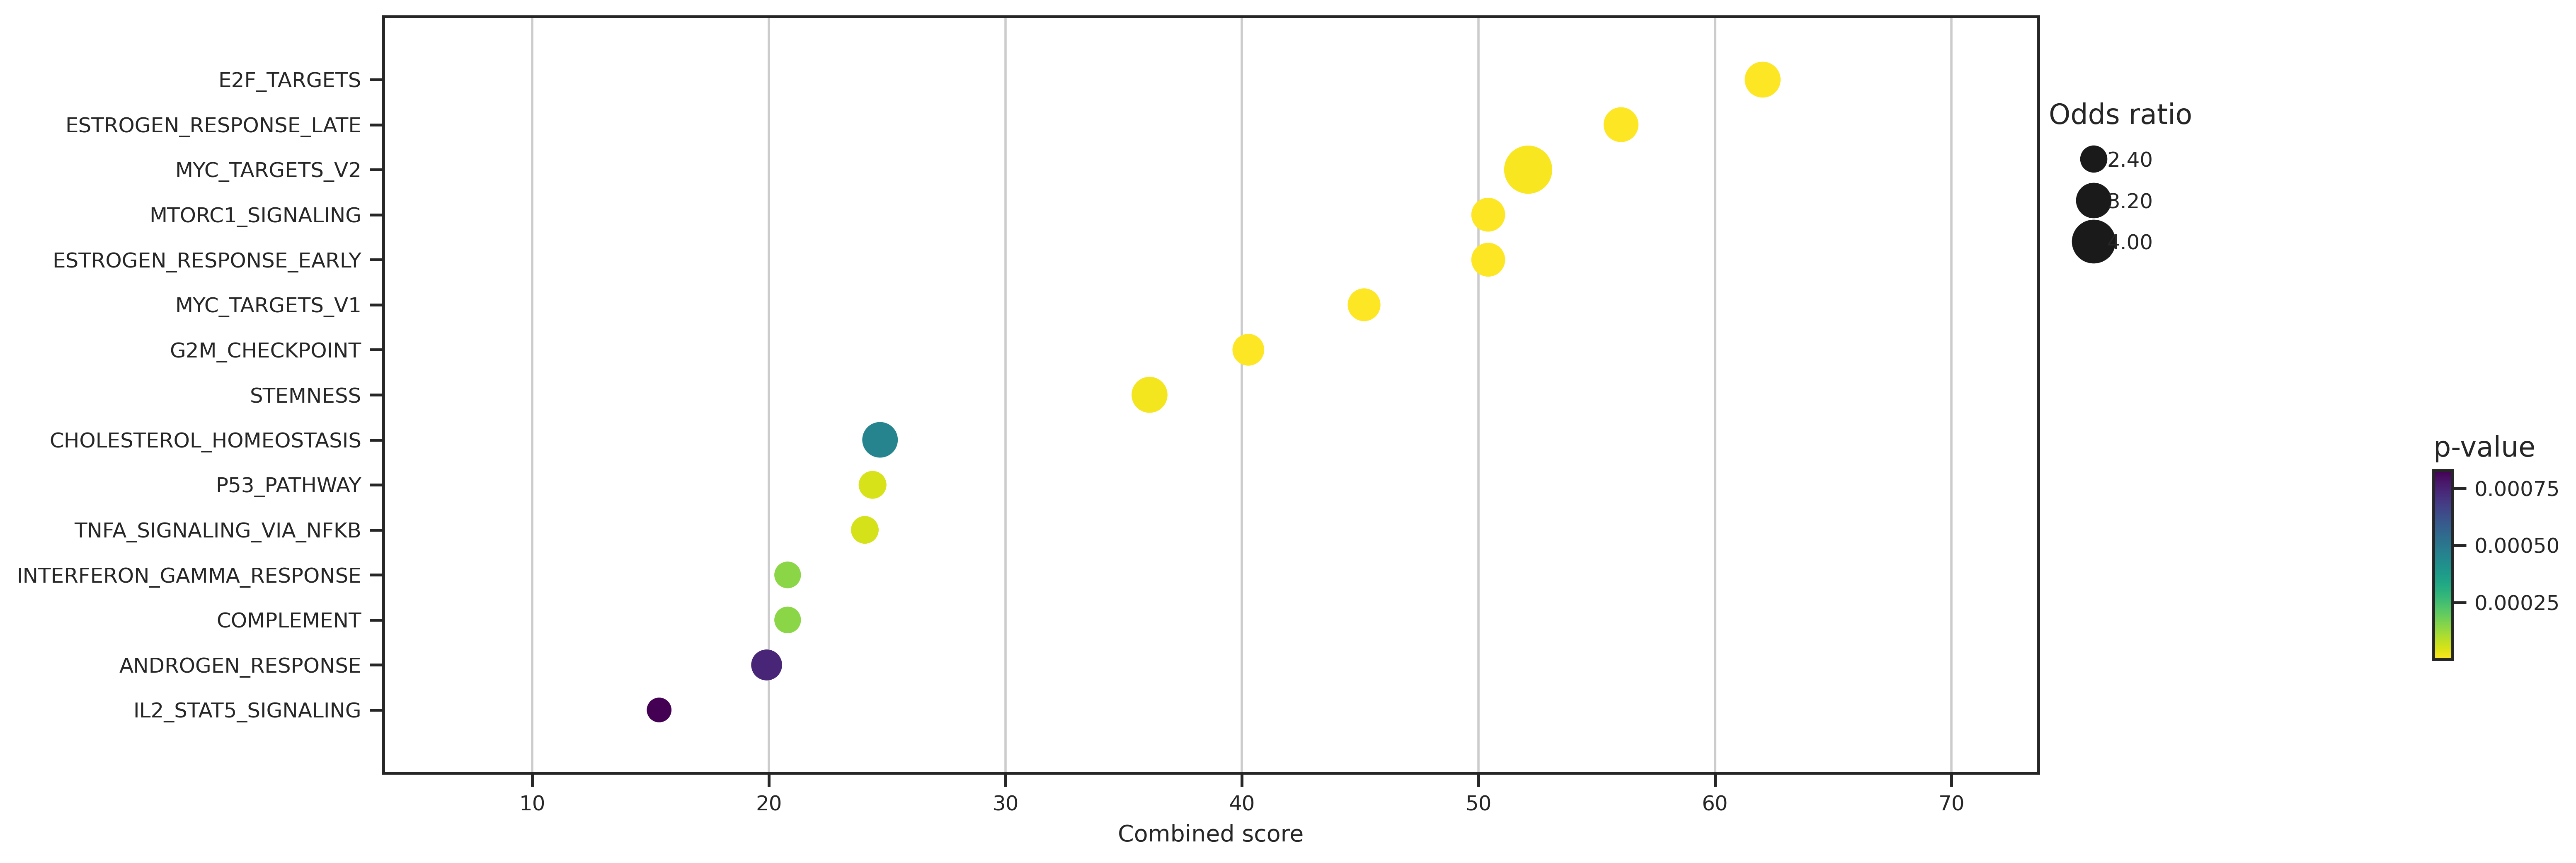

In [51]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='p-value',
    scale=0.75,
    dpi=200,
    figsize=(16,6)
)

# 旋转y轴标签
plt.xticks(rotation=0)  # 如果需要，可以调整为90度或其他角度

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.Epithelial_hallmark_functional_enrichment.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


We can also plot the running score for a given gene set:

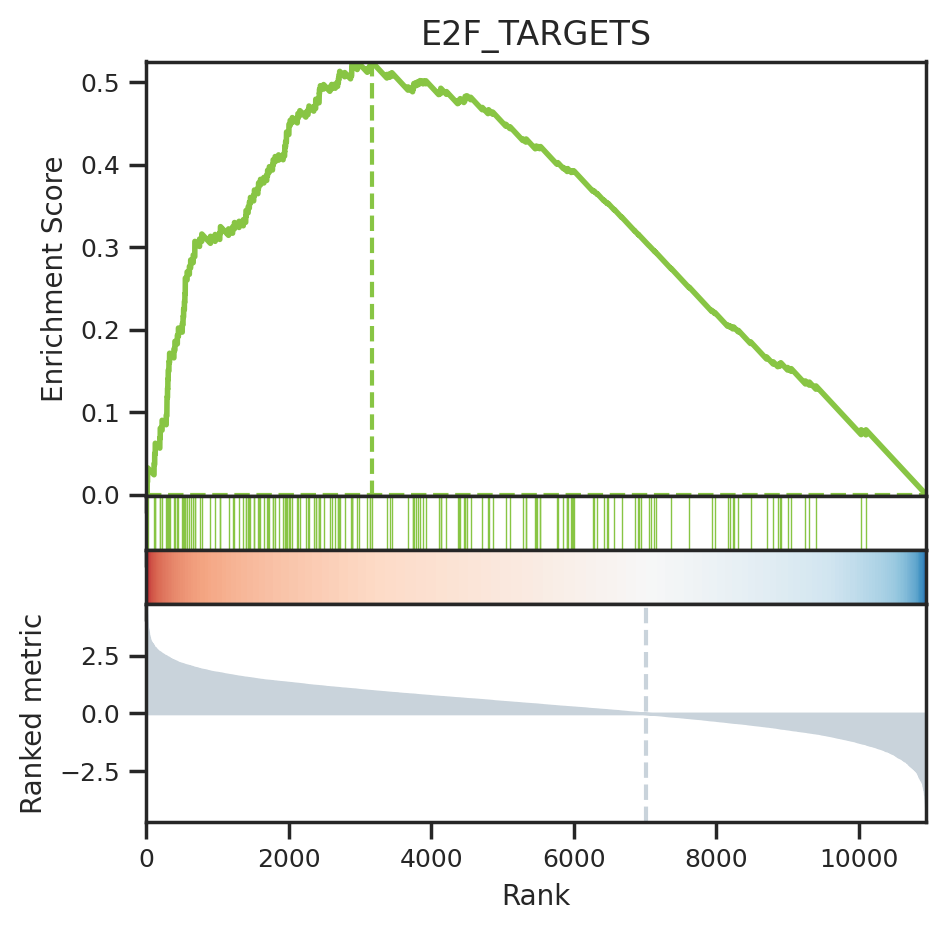

In [52]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='E2F_TARGETS',
    figsize=(5, 5)
)

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.Epithelial_E2F_TARGETS_enrichment.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

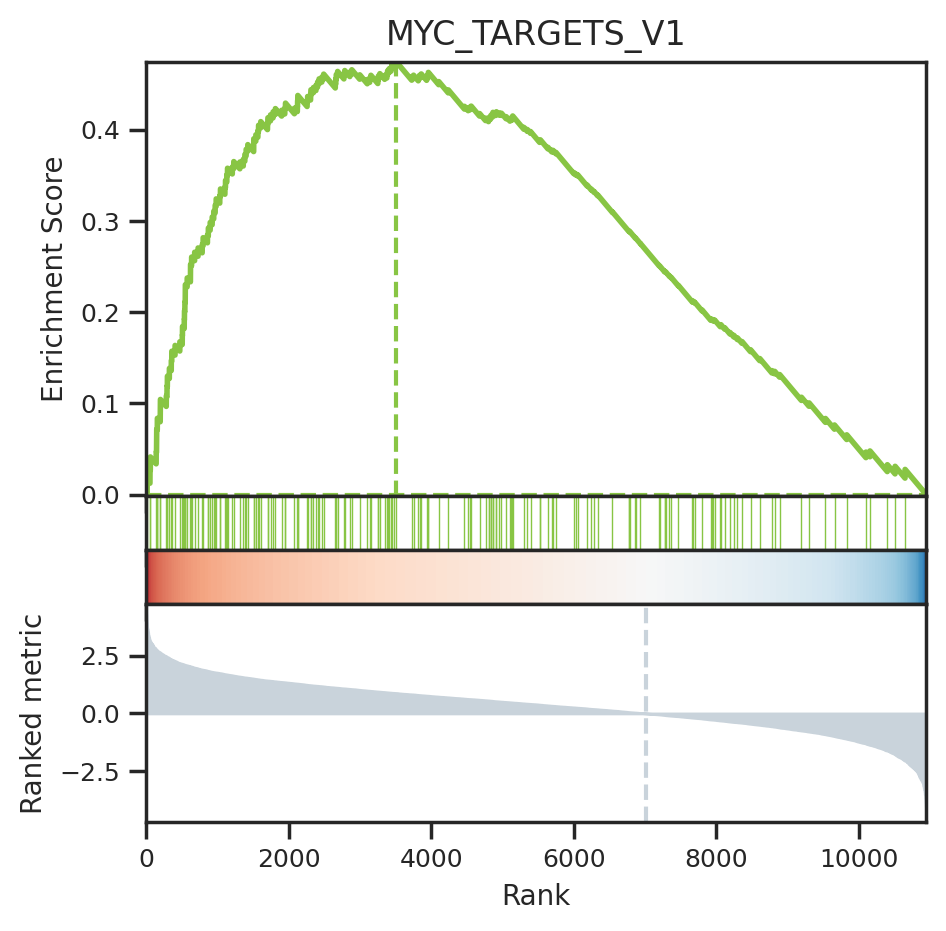

In [53]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1',
    figsize=(5, 5)
)

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.Epithelial_MYC_V1_enrichment.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

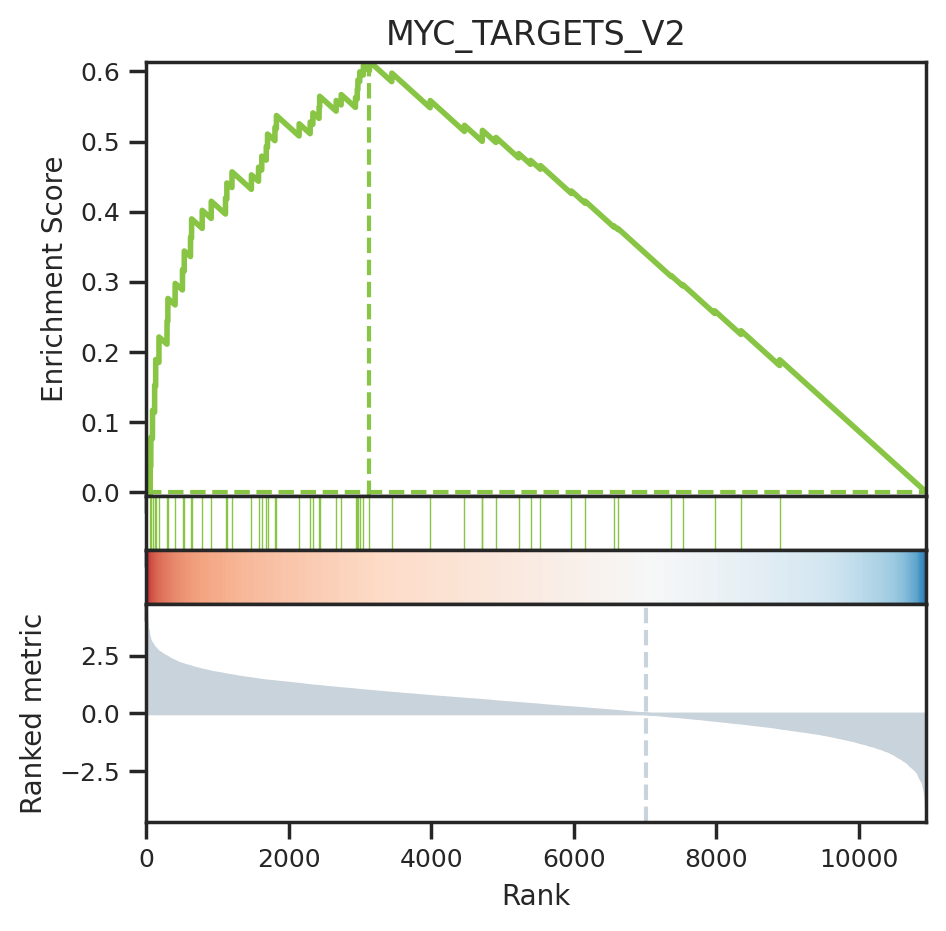

In [54]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V2',
    figsize=(5, 5)
)

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.Epithelial_MYC_V2_enrichment.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

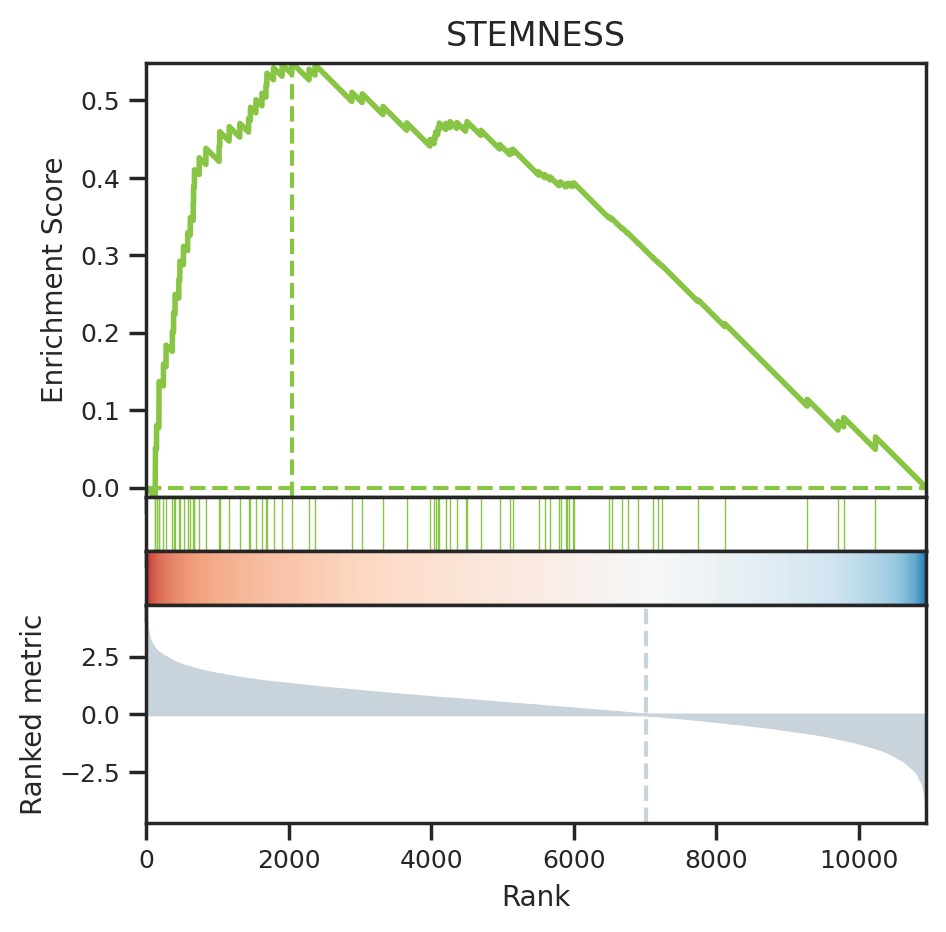

In [55]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='STEMNESS',
    figsize=(5, 5)
)

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.STEMNESS_enrichment.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()

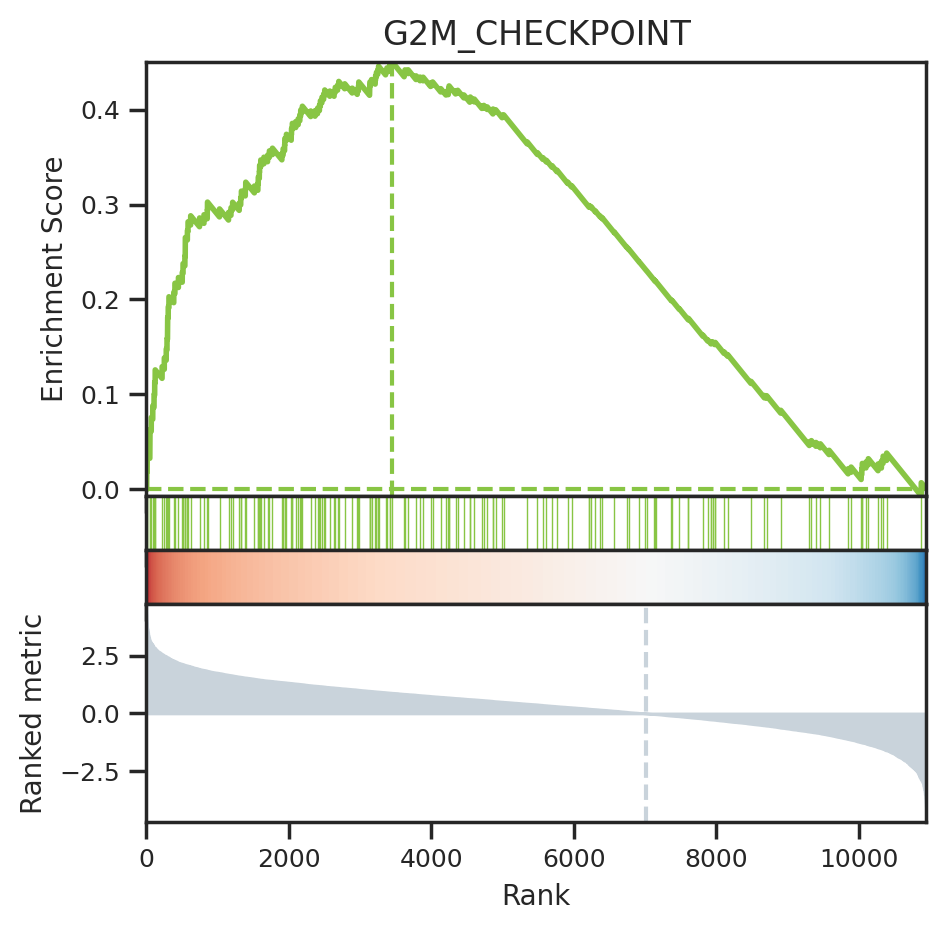

In [56]:
# Plot
dc.plot_running_score(
    df=results_df,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='G2M_CHECKPOINT',
    figsize=(5, 5)
)

# 保存为 PDF
plt.savefig('Results/06.Epithelial/06.G2M_CHECKPOINT_enrichment.pdf', format='pdf', bbox_inches='tight')

# 显示图形
plt.show()


**<span style="font-size:16px;">Session information：</span>**

In [57]:
import sys
import platform
import pkg_resources

# Get Python version information
python_version = sys.version
# Get operating system information
os_info = platform.platform()
# Get system architecture information
architecture = platform.architecture()[0]
# Get CPU information
cpu_info = platform.processor()
# Print Session information
print("Python version:", python_version)
print("Operating system:", os_info)
print("System architecture:", architecture)
print("CPU info:", cpu_info)

# Print imported packages and their versions
print("\nImported packages and their versions:")
for package in pkg_resources.working_set:
    print(package.key, package.version)

Python version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
Operating system: Linux-6.8.0-58-generic-x86_64-with-glibc2.35
System architecture: 64bit
CPU info: x86_64

Imported packages and their versions:
geneclust 1.0.0
squidpy 1.6.5
spagcn 1.2.7
leidenalg 0.10.2
igraph 0.11.8
hdbscan 0.8.40
loguru 0.7.3
zarr 2.18.4
xarray 2025.3.0
validators 0.34.0
tifffile 2025.3.13
spatialdata 0.3.0
cython 3.0.12
datetime 5.5
deprecated 1.2.18
markdown 3.7
markupsafe 2.1.5
pims 0.7
pot 0.9.5
pubchempy 1.0.4
pycomplexheatmap 1.8.1
pygsp 0.5.1
pyscipopt 5.3.0
pysocks 1.7.1
pywavelets 1.4.1
pyyaml 6.0.2
pyomo 6.8.2
send2trash 1.8.3
xlsxwriter 3.2.2
absl-py 2.1.0
ace-tools 0.0
adjusttext 1.3.0
aiobotocore 2.20.0
aiohappyeyeballs 2.4.6
aiohttp 3.11.12
aioitertools 0.12.0
aiosignal 1.3.2
anndata 0.11.3
annotated-types 0.7.0
annoy 1.17.3
anyio 4.8.0
appdirs 1.4.4
argcomplete 1.12.0
argon2-cffi 23.1.0
argon2-cffi-bindings 21.2.0
array-api-compat 1.10.0
arrow 1.3.0
arviz 